In [1]:
import os
import pandas as pd
import glm_utils
import re
import matplotlib.pyplot as plt
import seaborn as sns
import allen_utils
import NWB_reader_functions as nwb_reader
import numpy as np
import pathlib
import pickle


In [2]:

def post_hoc_load_model_results(filename, output_dir):

    file_path = os.path.join(output_dir, '{}_results.parquet'.format(filename))
    try:
        result_df = pd.read_parquet(file_path)
    except FileNotFoundError:
        print('No model results found in:', file_path)
        return None
    return result_df
def load_model_input_output(output_dir):
    with open(os.path.join(output_dir), 'rb') as f:
        data = pickle.load(f)
    X = data['input']
    data.keys()
    spikes = data['output']
    feature_names = data['feature_names']
    commit_hash = data['commit_hash']
    # neurons_id = data['neurons_id']
    return X, spikes, feature_names

In [37]:
experimenter = 'Axel_Bisi'
models_path = r"M:\analysis\Myriam_Hamon\results\AB131\whisker_0\server/models"
nwb_path = os.path.join('\\\\sv-nas1.rcp.epfl.ch', 'Petersen-Lab', 'analysis', experimenter, 'NWBFull')
subject_id = 'AB131'
all_nwb_names = os.listdir(nwb_path)
nwb_names = [name for name in all_nwb_names if subject_id in name]
subject_nwb_files = [os.path.join(nwb_path, name) for name in nwb_names]
subject_nwb_neural_files = []
 #TODO get the model data instead !!
# Keep whisker day 0 files with neural data
if experimenter == 'Axel_Bisi':
    for nwb_file in subject_nwb_files: # keep whisker day 0 only
        beh, day = nwb_reader.get_bhv_type_and_training_day_index(nwb_file)
        if beh=='whisker' and day==0:
            unit_table = nwb_reader.get_unit_table(nwb_file)
            unit_table = unit_table.sample(frac=1)
            unit_table = unit_table[unit_table['bc_label']=='good']
            # unit_table = unit_table[unit_table['ccf_parent_acronym'].isin(['SSp-bfd', 'SSs'])]
            unit_table = unit_table[unit_table['firing_rate'].astype(float).ge(2.0)]
            unit_table = unit_table[~unit_table['ccf_acronym'].isin(allen_utils.get_excluded_areas())]

            # Use index as new column named "unit_id", then reset
            unit_table['neuron_id'] = unit_table.index
            unit_table.reset_index(drop=True, inplace=True)
            neurons_ccf = unit_table['ccf_parent_acronym'].values


            if unit_table is not None:

                # Collect for aggregated mice analyses
                nwb_neural_files = nwb_file
                break
trials_df = nwb_reader.get_trial_table(nwb_neural_files)
trials_df = trials_df[(trials_df['context'] == 'active') &(trials_df['perf'] != 6)].copy()
trials_df = trials_df.reset_index(drop=True)


In [9]:
len(neurons_ccf)


344

In [16]:

all_results = []

for file in os.listdir(models_path):
    if file.endswith('_results.parquet'):
        # Extract git version and fold using regex
        match = re.match(r'([a-f0-9]+)_model_(full|reduced)_fold(\d+)_results\.parquet', file)
        if match:
            git_version = match.group(1)
            fold = int(match.group(3))
            model_type = match.group(2)

            # Load DataFrame
            df = post_hoc_load_model_results(file.split("_results")[0], models_path)

            # Add metadata
            df['git_version'] = git_version
            df['fold'] = fold
            df['model_type'] = model_type

            all_results.append(df)


df = pd.concat(all_results, ignore_index=True)


In [3]:
data_path = r"M:\analysis\Myriam_Hamon\results\AB131\whisker_0\server\data\851aacc\data.pkl"
X, spikes, feature_names = load_model_input_output(data_path)



In [5]:
feature_names

['trial_index_scaled',
 'prev_whisker_reward',
 'prev_auditory_reward',
 'prop_past_whisker_rewarded',
 'prop_past_auditory_rewarded',
 'dlc_lick_onset_t-0.20s',
 'dlc_lick_onset_t-0.10s',
 'dlc_lick_onset_t+0.00s',
 'dlc_lick_onset_t+0.10s',
 'dlc_lick_onset_t+0.20s',
 'dlc_lick_onset_t+0.30s',
 'dlc_lick_onset_t+0.40s',
 'auditory_stim_t-0.20s',
 'auditory_stim_t-0.10s',
 'auditory_stim_t+0.00s',
 'auditory_stim_t+0.10s',
 'auditory_stim_t+0.20s',
 'auditory_stim_t+0.30s',
 'auditory_stim_t+0.40s',
 'whisker_stim_t-0.20s',
 'whisker_stim_t-0.10s',
 'whisker_stim_t+0.00s',
 'whisker_stim_t+0.10s',
 'whisker_stim_t+0.20s',
 'whisker_stim_t+0.30s',
 'whisker_stim_t+0.40s',
 'jaw_dist',
 'pupil_area',
 'whisker_vel',
 'nose_dist']

In [14]:
reduced_feature_groups = {
    'whisker_encoding': [f for f in feature_names if 'whisker_stim_t' in f],
    'auditory_encoding': [f for f in feature_names if 'auditory_stim_t' in f],
    'whisker_reward_encoding': ['prev_whisker_reward'],
    'auditory_reward_encoding': ['prev_auditory_reward'],
    'lick_onset_encoding': [f for f in feature_names if 'dlc_lick_onset' in f],
    'motor_encoding': [f for f in feature_names if 'dist' in f or 'vel' in f],
    'whisker_move' : [ 'whisker_vel'],
    'session_progress_encoding': ['trial_index_scaled'],
    'last_rewards_whisker': ['last_whisker_reward'],
    'last_rewards_auditory': ['last_auditory_reward'],
    'prop_rewards_whiskers': ['prop_past_whisker_rewarded'],
    'prop_rewards_auditory': ['prop_past_auditory_reward'],
    'prop_last_5_whisker': ['whisker_reward_rate_5'],
    'prop_last_5_auditoy' :[ 'auditory_reward_rate_5'],
    'cum_rewards_whisker': ['sum_whisker_reward_scaled'],
    'cum_rewards_auditory': ['sum_auditory_reward_scaled'],
    'all_whisker_progression' :['prev_whisker_reward','last_whisker_reward', 'prop_past_whisker_rewarded', 'whisker_reward_rate_5', 'sum_whisker_reward_scaled' ],
    'all_auditory_progression' :['prev_auditory_reward','last_auditory_reward', 'prop_past_auditory_rewarded', 'auditory_reward_rate_5', 'sum_auditory_reward_scaled' ],
    'all_progression' :['prev_whisker_reward','last_whisker_reward', 'prop_past_whisker_rewarded', 'whisker_reward_rate_5', 'sum_whisker_reward_scaled','prev_auditory_reward','last_auditory_reward', 'prop_past_auditory_rewarded', 'auditory_reward_rate_5', 'sum_auditory_reward_scaled'   ],
    'last_rewards': ['last_whisker_reward', 'last_auditory_reward'],
    'prop_rewards': ['prop_past_whisker_rewarded', 'prop_past_auditory_rewarded'],
    'prop_last_5': ['whisker_reward_rate_5', 'auditory_reward_rate_5'],
    'cum_rewards': ['sum_whisker_reward_scaled', 'sum_auditory_reward_scaled']
}
print(reduced_feature_groups)

{'whisker_encoding': ['whisker_stim_t-0.20s', 'whisker_stim_t-0.10s', 'whisker_stim_t+0.00s', 'whisker_stim_t+0.10s', 'whisker_stim_t+0.20s', 'whisker_stim_t+0.30s', 'whisker_stim_t+0.40s'], 'auditory_encoding': ['auditory_stim_t-0.20s', 'auditory_stim_t-0.10s', 'auditory_stim_t+0.00s', 'auditory_stim_t+0.10s', 'auditory_stim_t+0.20s', 'auditory_stim_t+0.30s', 'auditory_stim_t+0.40s'], 'whisker_reward_encoding': ['prev_whisker_reward'], 'auditory_reward_encoding': ['prev_auditory_reward'], 'lick_onset_encoding': ['dlc_lick_onset_t-0.20s', 'dlc_lick_onset_t-0.10s', 'dlc_lick_onset_t+0.00s', 'dlc_lick_onset_t+0.10s', 'dlc_lick_onset_t+0.20s', 'dlc_lick_onset_t+0.30s', 'dlc_lick_onset_t+0.40s'], 'motor_encoding': ['jaw_dist', 'whisker_vel', 'nose_dist'], 'session_progress_encoding': ['trial_index_scaled'], 'last_rewards_whisker': ['last_whisker_reward'], 'last_rewards_auditory': ['last_auditory_reward'], 'prop_rewards_whiskers': ['prop_past_whisker_rewarded'], 'prop_rewards_auditory': ['p

In [15]:
max_combo_size = 3

In [16]:
from itertools import combinations
all_combos = []
group_names = list(reduced_feature_groups.keys())

for r in range(1, max_combo_size + 1):
    for combo in combinations(group_names, r):
        combo_name = '_'.join(combo)
        removed_features = []
        for group in combo:
            removed_features.extend(reduced_feature_groups[group])
        all_combos.append({'name': combo_name, 'features_to_remove': removed_features})

# Save to file


In [18]:
all_combos

[{'name': 'whisker_encoding',
  'features_to_remove': ['whisker_stim_t-0.20s',
   'whisker_stim_t-0.10s',
   'whisker_stim_t+0.00s',
   'whisker_stim_t+0.10s',
   'whisker_stim_t+0.20s',
   'whisker_stim_t+0.30s',
   'whisker_stim_t+0.40s']},
 {'name': 'auditory_encoding',
  'features_to_remove': ['auditory_stim_t-0.20s',
   'auditory_stim_t-0.10s',
   'auditory_stim_t+0.00s',
   'auditory_stim_t+0.10s',
   'auditory_stim_t+0.20s',
   'auditory_stim_t+0.30s',
   'auditory_stim_t+0.40s']},
 {'name': 'whisker_reward_encoding',
  'features_to_remove': ['prev_whisker_reward']},
 {'name': 'auditory_reward_encoding',
  'features_to_remove': ['prev_auditory_reward']},
 {'name': 'lick_onset_encoding',
  'features_to_remove': ['dlc_lick_onset_t-0.20s',
   'dlc_lick_onset_t-0.10s',
   'dlc_lick_onset_t+0.00s',
   'dlc_lick_onset_t+0.10s',
   'dlc_lick_onset_t+0.20s',
   'dlc_lick_onset_t+0.30s',
   'dlc_lick_onset_t+0.40s']},
 {'name': 'motor_encoding',
  'features_to_remove': ['jaw_dist', 'whis

In [10]:
# Define the mapping from git_version code to descriptive label
git_mapping = {
    'd223228': 'without prop_whisker_rewarded',
    '851aacc': 'with prop_whisker_rewarded',
    'ad9dbf2' : 'more learning predictors'
}

# Apply the mapping
df['git_version'] = df['git_version'].replace(git_mapping)

In [11]:
df['fold'].unique()

array([0, 4, 2, 3, 1], dtype=int64)

In [12]:
df['git_version'].unique()

array(['more learning predictors', 'without prop_whisker_rewarded',
       'with prop_whisker_rewarded'], dtype=object)

In [15]:
df.keys()

NameError: name 'df' is not defined

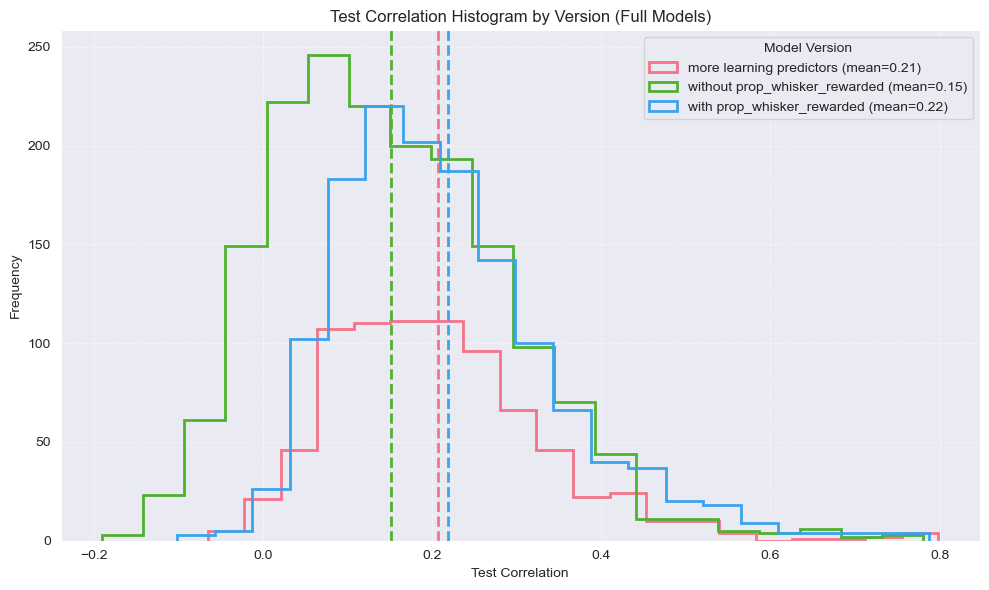

In [20]:

df_full = df[df['model_type'] =='full']

plt.figure(figsize=(10, 6))

# Pick unique git versions
git_versions = df_full['git_version'].unique()
colors = sns.color_palette("husl", len(git_versions))  # distinct colors

# Plot unfilled histograms per git version
for git_version, color in zip(git_versions, colors):

    sub_df = df_full[df_full['git_version'] == git_version]
    plt.hist(sub_df['test_corr'], bins=20, histtype='step', linewidth=2,
             label=f'{git_version} (mean={sub_df["test_corr"].mean():.2f})', color=color)
    mean_corr = sub_df['test_corr'].mean()
    plt.axvline(mean_corr, color=color, linestyle='--', linewidth=2)
# Style the plot
plt.title('Test Correlation Histogram by Version (Full Models)')
plt.xlabel('Test Correlation')
plt.ylabel('Frequency')
plt.legend(title='Model Version')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

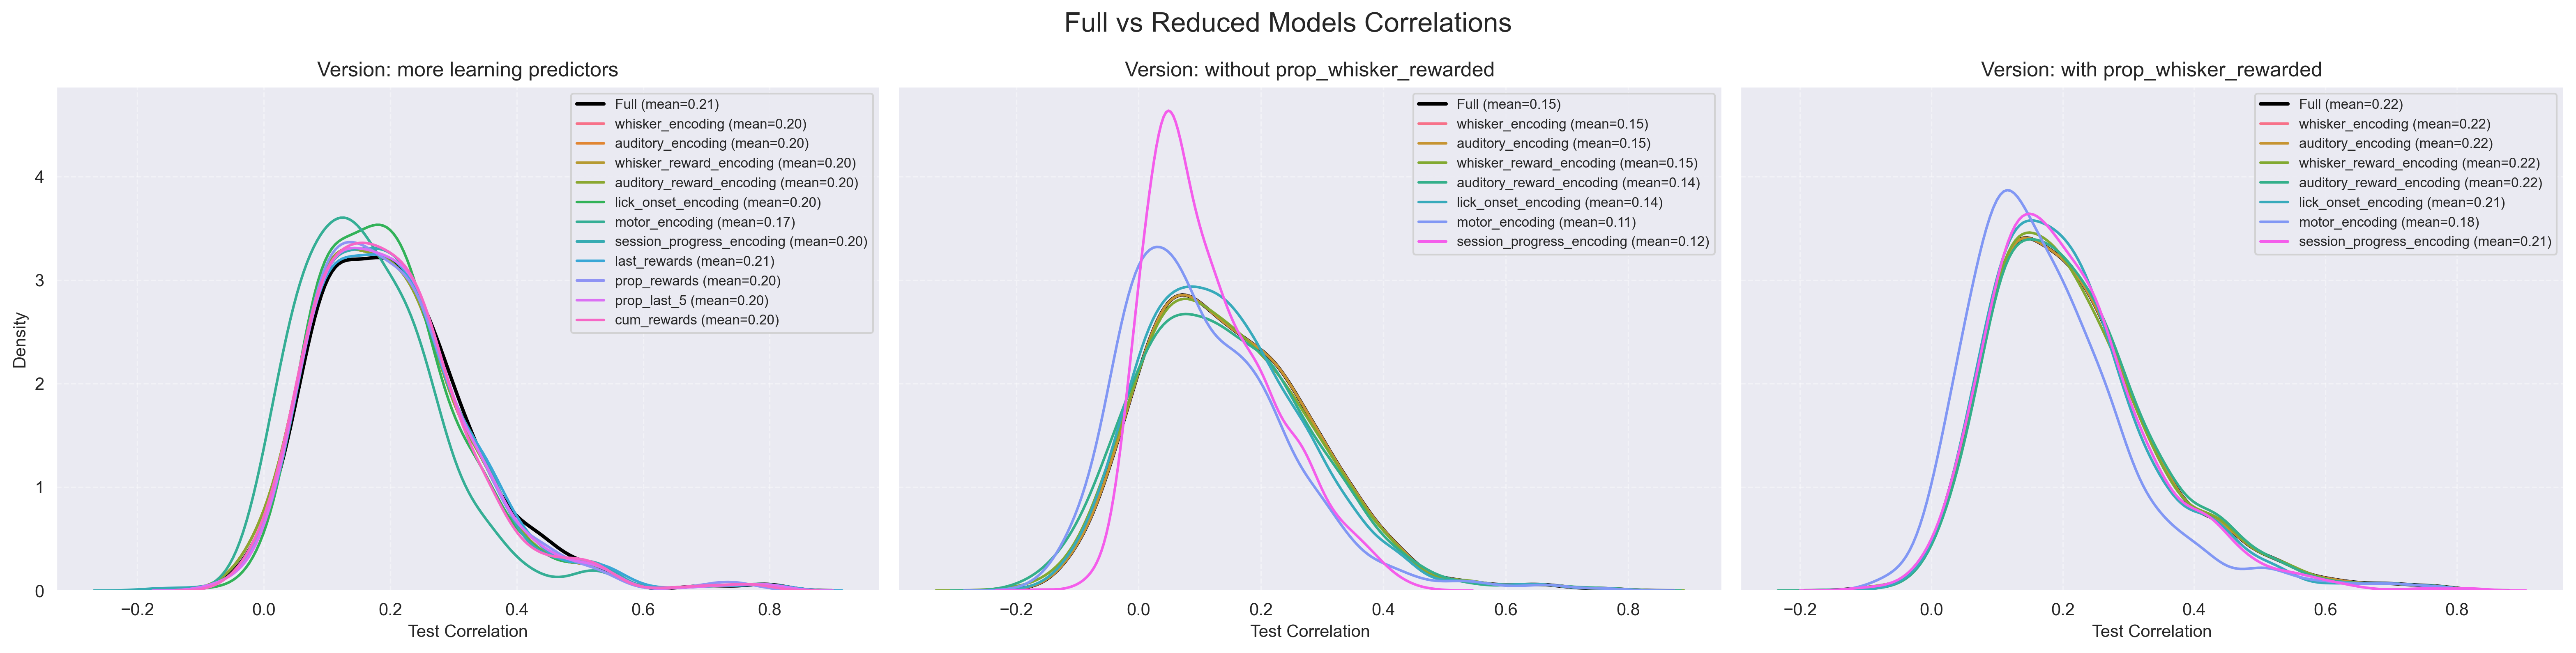

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique git versions
git_versions = df['git_version'].unique()
n_versions = len(git_versions)

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=n_versions, figsize=(7 * n_versions, 5), dpi=300, sharey=True)

if n_versions == 1:
    axes = [axes]  # Make iterable

for ax, git_version in zip(axes, git_versions):
    df_git = df[df['git_version'] == git_version]

    # Plot full model
    df_full = df_git[df_git['model_type'] == 'full']
    sns.kdeplot(df_full['test_corr'], ax=ax, color='black', linewidth=2, label=f'Full (mean={df_full["test_corr"].mean():.2f})')

    # Plot reduced models
    df_reduced = df_git[df_git['model_type'] == 'reduced']
    reduced_model_names = df_reduced['model_name'].unique()
    colors = sns.color_palette("husl", len(reduced_model_names))

    for color, model_name in zip(colors, reduced_model_names):
        sub_df = df_reduced[df_reduced['model_name'] == model_name]
        if not sub_df.empty:
            sns.kdeplot(sub_df['test_corr'], ax=ax, color=color, linewidth=1.5,
                        label=f'{model_name} (mean={sub_df["test_corr"].mean():.2f})')

    ax.set_title(f'Version: {git_version}')
    ax.set_xlabel('Test Correlation')
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.suptitle('Full vs Reduced Models Correlations', fontsize=16, y=1.05)
plt.show()


Text(0.5, 1.05, 'Full vs Reduced Models pr2')

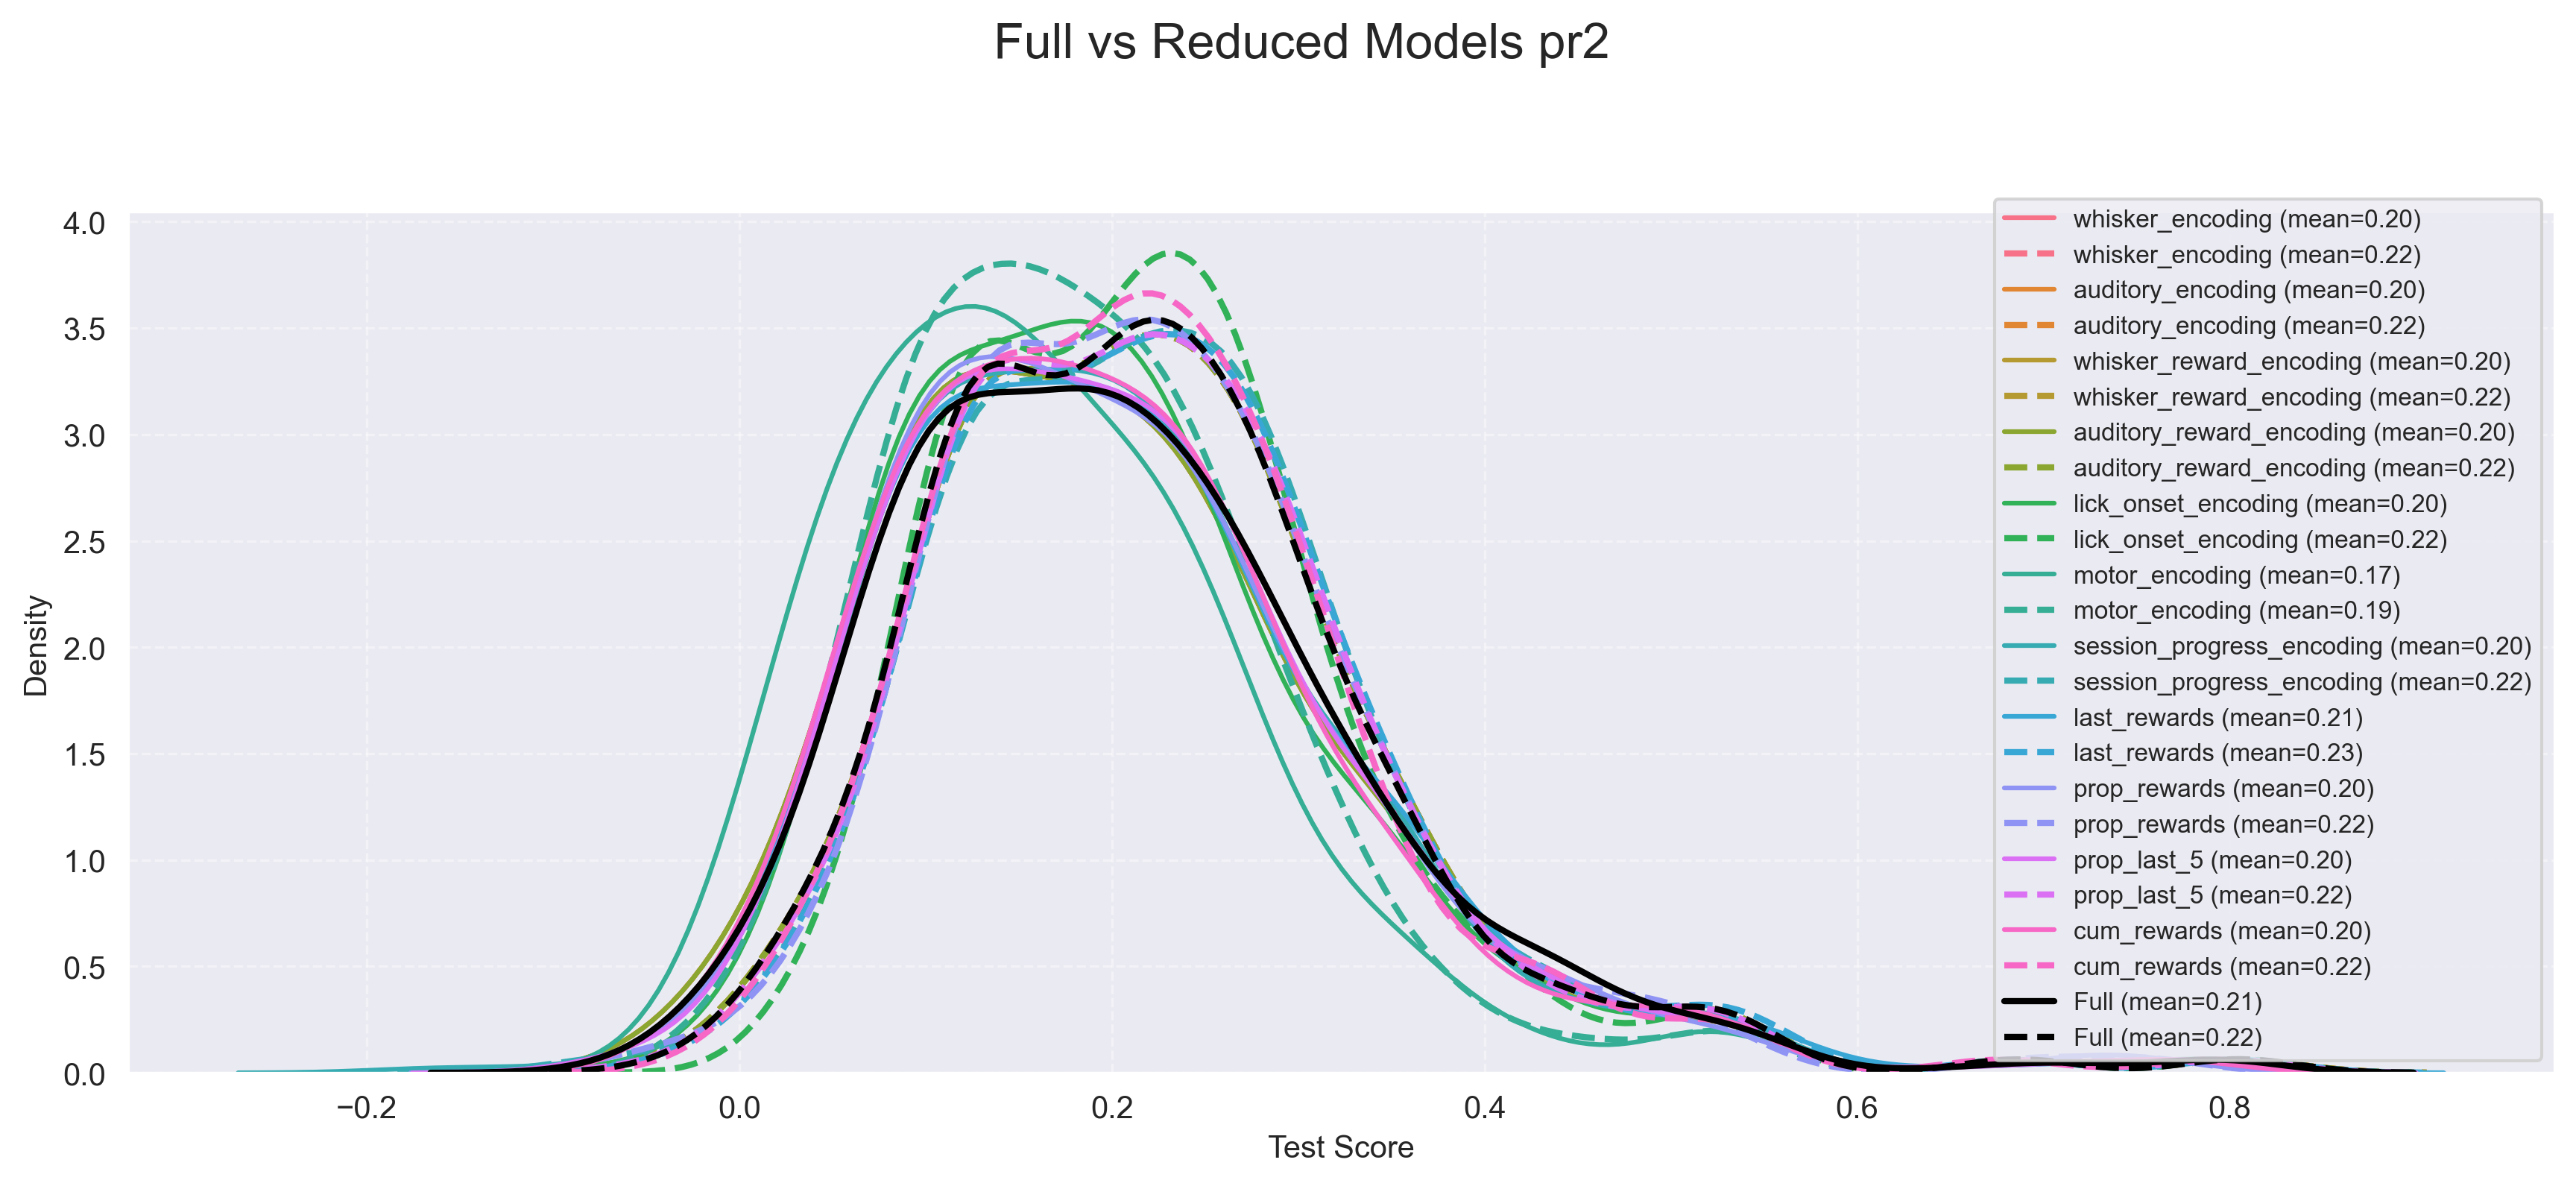

In [16]:
df['git_version'].unique()
n_versions = 1

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=n_versions, figsize=(7 * 2, 5), dpi=300, sharey=True)

if n_versions == 1:
    axes = [axes]  # Make iterable

for ax, git_version in zip(axes, ['more learning predictors']):
    df_git = df[df['git_version'] == git_version]


    # Plot reduced models
    df_reduced = df_git[df_git['model_type'] == 'reduced']
    reduced_model_names = df_reduced['model_name'].unique()
    colors = sns.color_palette("husl", len(reduced_model_names))

    for color, model_name in zip(colors, reduced_model_names):
        sub_df = df_reduced[df_reduced['model_name'] == model_name]
        if not sub_df.empty:
            sns.kdeplot(sub_df['test_corr'], ax=ax, color=color, linewidth=1.5,
                        label=f'{model_name} (mean={sub_df["test_corr"].mean():.2f})')
            sns.kdeplot(sub_df['train_corr'], ax=ax, color=color, linewidth=2, linestyle='--', label=f'{model_name} (mean={sub_df["train_corr"].mean():.2f})')

        # Plot full model
    df_full = df_git[df_git['model_type'] == 'full']
    sns.kdeplot(df_full['test_corr'], ax=ax, color='black', linewidth=2, label=f'Full (mean={df_full["test_corr"].mean():.2f})')
    sns.kdeplot(df_full['train_corr'], ax=ax, color='black', linewidth=2, linestyle='--', label=f'Full (mean={df_full["train_corr"].mean():.2f})')


    ax.set_xlabel('Test Score')
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.4)
plt.suptitle('Full vs Reduced Models pr2', fontsize=16, y=1.05)



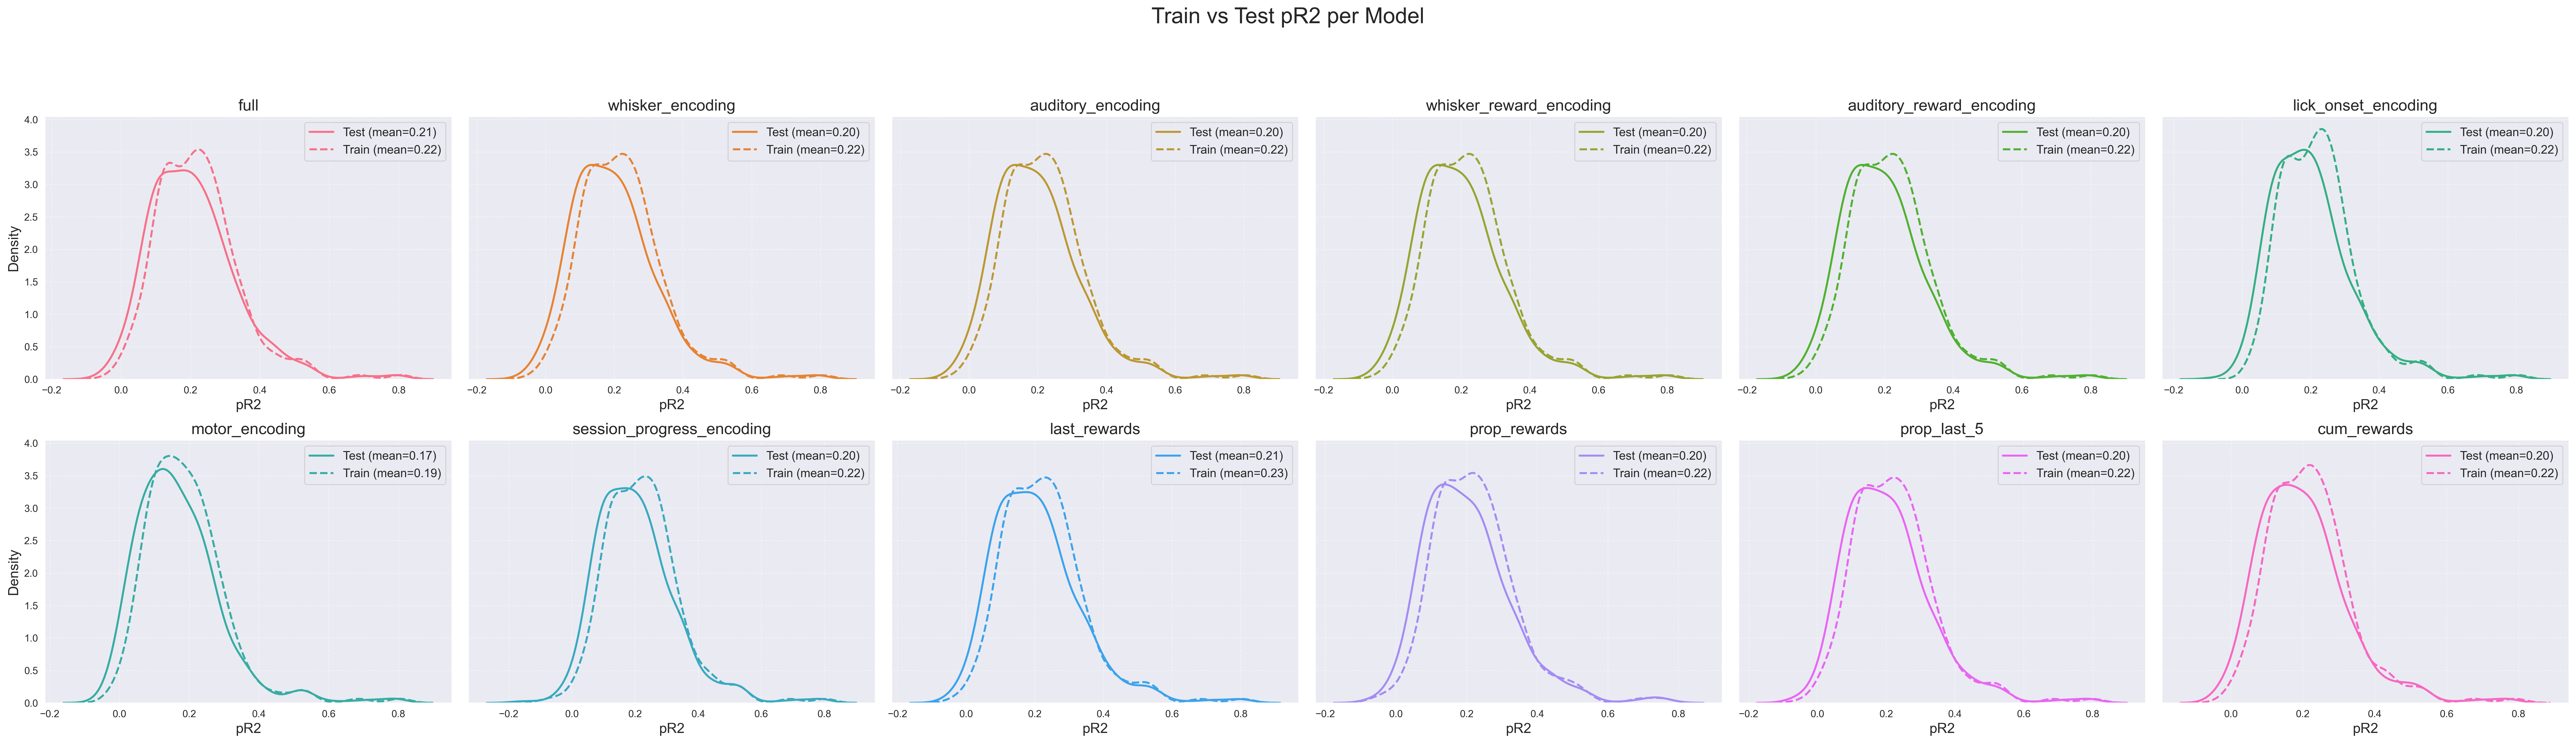

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Filter by git_version
git_version = 'more learning predictors'
df_git = df[df['git_version'] == git_version]

# Get unique model names
model_names = df_git['model_name'].unique()
n_models = len(model_names)

# Determine subplot layout: 2 rows
ncols = math.ceil(n_models / 2)
nrows = 2

# Set up subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows), dpi=300, sharey=True)
axes = axes.flatten()

# Assign colors per model
colors = sns.color_palette("husl", n_models)

# Plot each model
for ax, model_name, color in zip(axes, model_names, colors):
    sub_df = df_git[df_git['model_name'] == model_name]

    if not sub_df.empty:
        # Plot test (solid)
        sns.kdeplot(sub_df['test_corr'], ax=ax, color=color, linewidth=2,
                    label=f'Test (mean={sub_df["test_corr"].mean():.2f})')
        # Plot train (dashed)
        sns.kdeplot(sub_df['train_corr'], ax=ax, color=color, linewidth=2, linestyle='--',
                    label=f'Train (mean={sub_df["train_corr"].mean():.2f})')

    ax.set_title(model_name, fontsize=16)
    ax.set_xlabel('pR2', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)

# Adjust overall layout
plt.suptitle('Train vs Test pR2 per Model', fontsize=22, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.96])


In [41]:
df_full['neuron_id'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

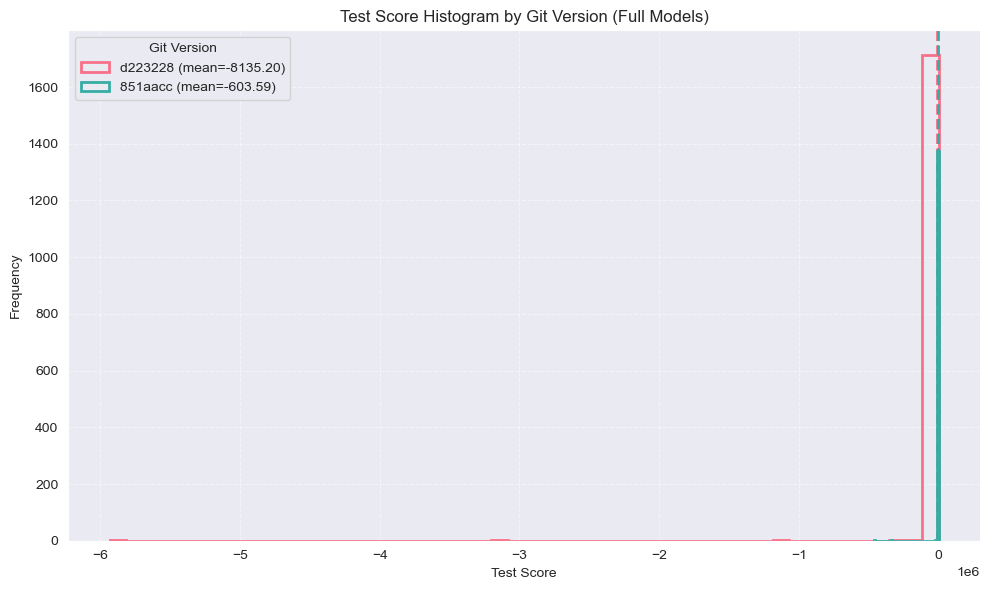

In [7]:
plt.figure(figsize=(10, 6))

# Pick unique git versions
git_versions = df_full['git_version'].unique()
colors = sns.color_palette("husl", len(git_versions))  # distinct colors

# Plot unfilled histograms per git version
for git_version, color in zip(git_versions, colors):
    sub_df = df_full[df_full['git_version'] == git_version]
    plt.hist(sub_df['test_score'], bins=50, histtype='step', linewidth=2,
             label=f'{git_version} (mean={sub_df["test_score"].mean():.2f})', color=color)
    mean_corr = sub_df['test_score'].mean()
    plt.axvline(mean_corr, color=color, linestyle='--', linewidth=2)
# Style the plot
# plt.xlim(-3,3)
plt.title('Test Score Histogram by Git Version (Full Models)')
plt.xlabel('Test Score')
plt.ylabel('Frequency')
plt.legend(title='Git Version')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

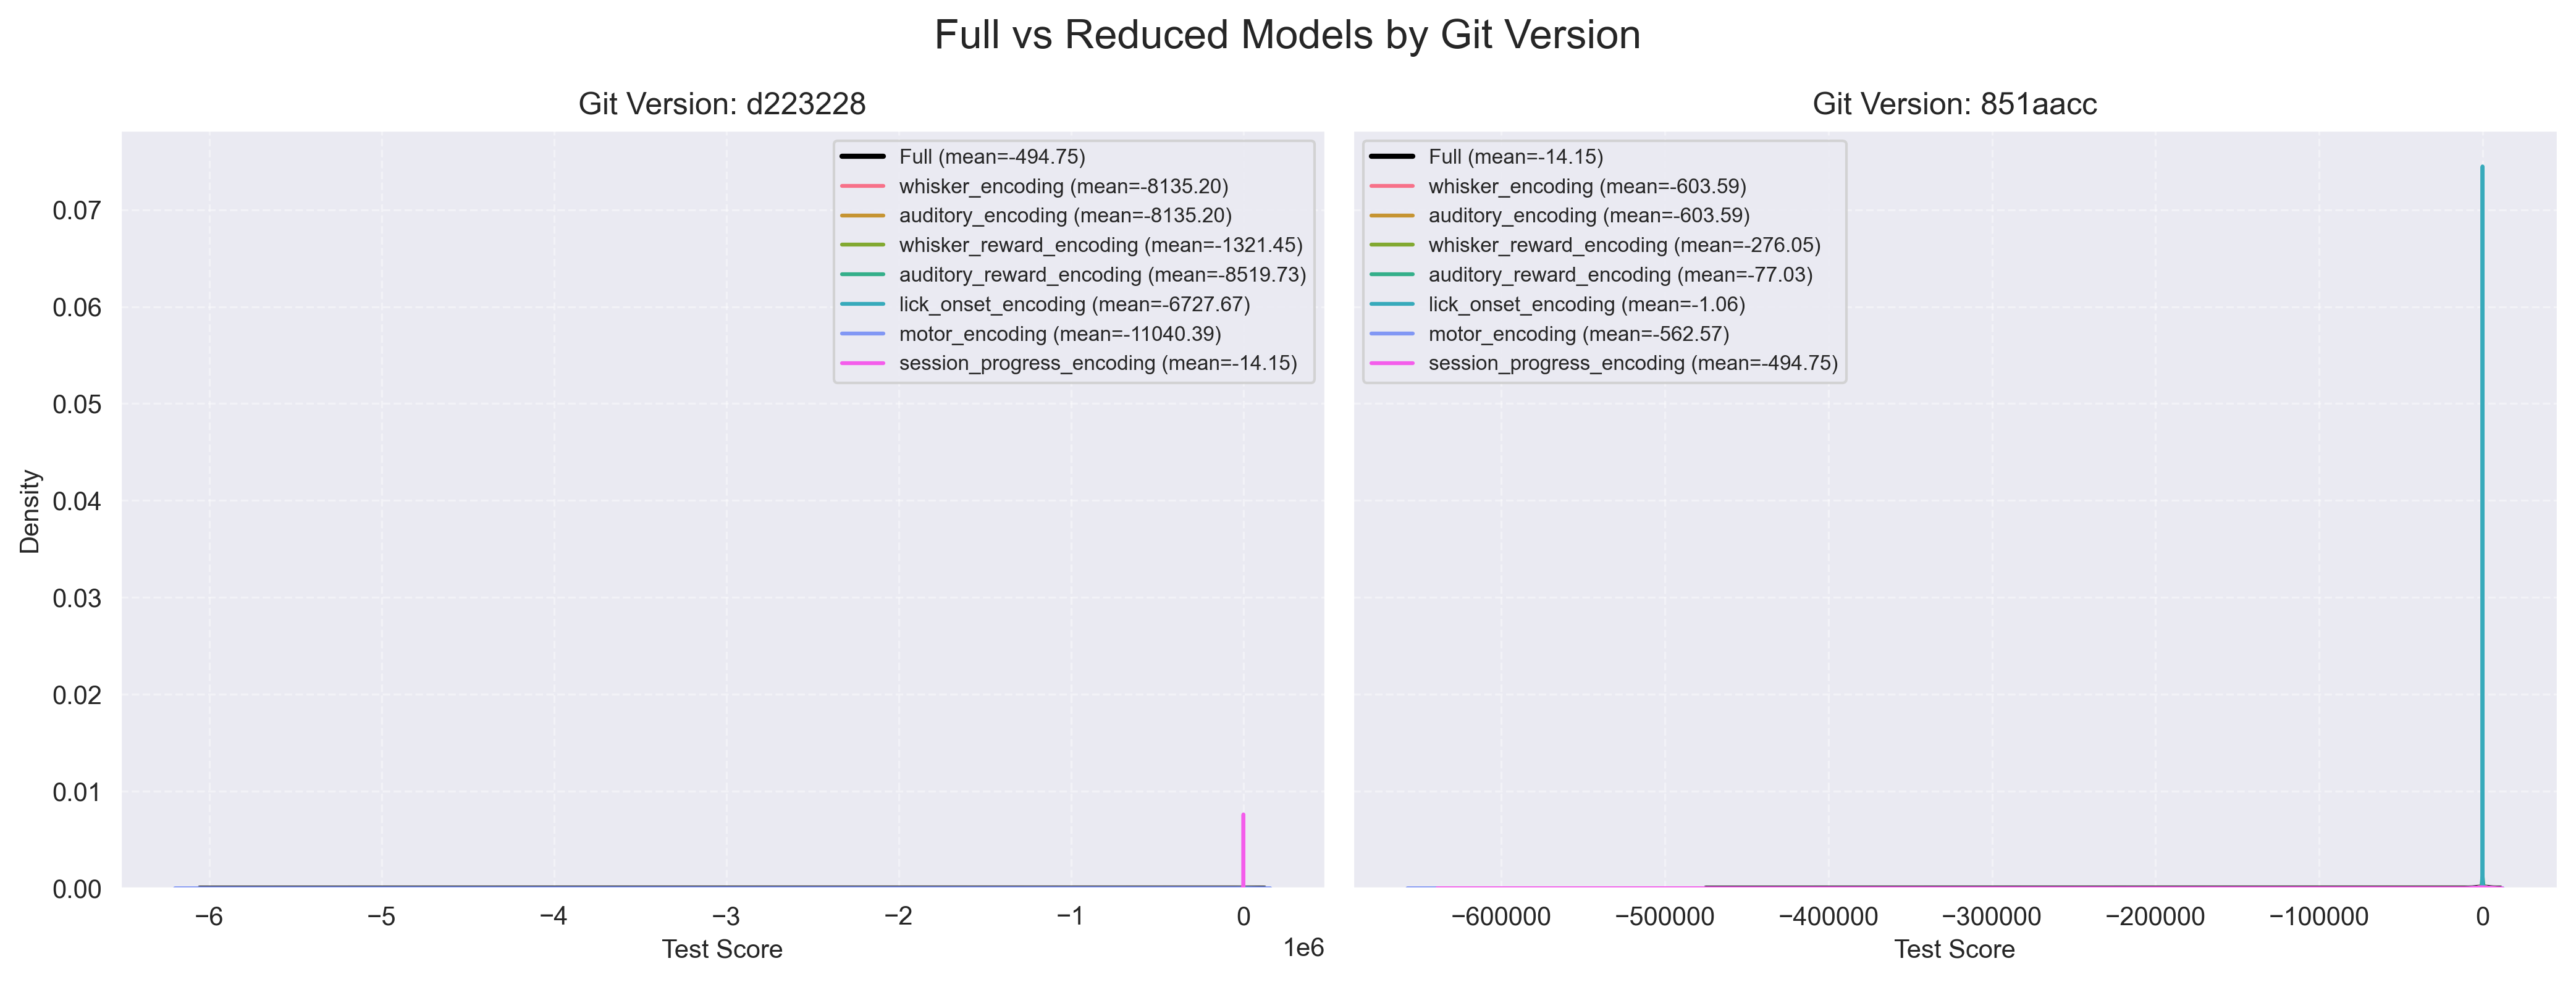

In [15]:
# Get unique git versions
git_versions = df['git_version'].unique()
n_versions = len(git_versions)

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=n_versions, figsize=(7 * n_versions, 5), dpi=300, sharey=True)

if n_versions == 1:
    axes = [axes]  # Make iterable

for ax, git_version in zip(axes, git_versions):
    df_git = df[df['git_version'] == git_version]

    # Plot full model
    df_full = df_git[df_git['model_type'] == 'full']
    sns.kdeplot(df_full['test_score'], ax=ax, color='black', linewidth=2, label=f'Full (mean={sub_df["test_score"].mean():.2f})')

    # Plot reduced models
    df_reduced = df_git[df_git['model_type'] == 'reduced']
    reduced_model_names = df_reduced['model_name'].unique()
    colors = sns.color_palette("husl", len(reduced_model_names))

    for color, model_name in zip(colors, reduced_model_names):
        sub_df = df_reduced[df_reduced['model_name'] == model_name]
        if not sub_df.empty:
            sns.kdeplot(sub_df['test_score'], ax=ax, color=color, linewidth=1.5,
                        label=f'{model_name} (mean={sub_df["test_score"].mean():.2f})')

    ax.set_title(f'Git Version: {git_version}')
    ax.set_xlabel('Test Score')
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.suptitle('Full vs Reduced Models by Git Version', fontsize=16, y=1.05)
plt.show()

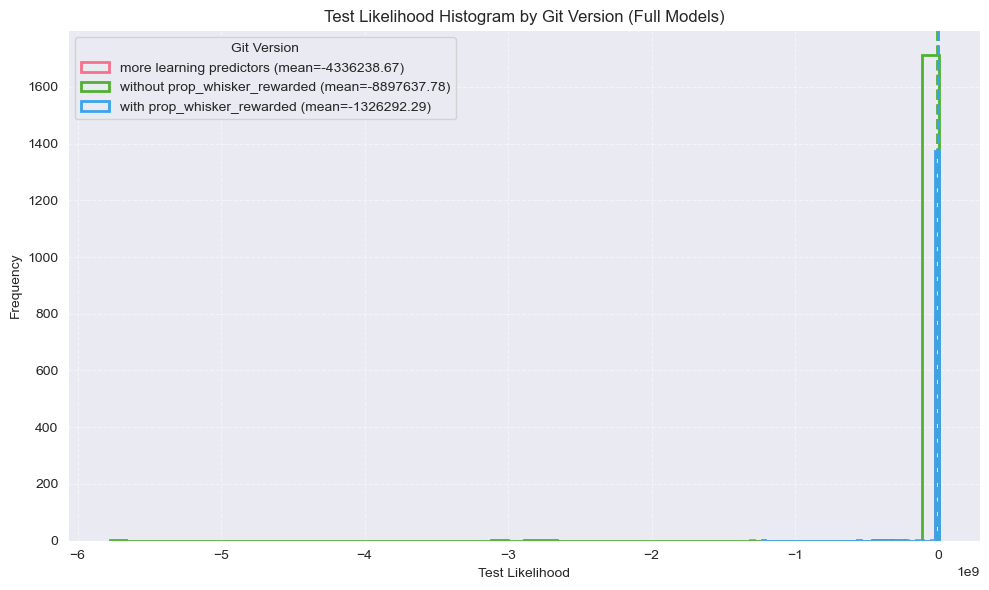

In [21]:
plt.figure(figsize=(10, 6))

# Pick unique git versions
git_versions = df_full['git_version'].unique()
colors = sns.color_palette("husl", len(git_versions))  # distinct colors

# Plot unfilled histograms per git version
for git_version, color in zip(git_versions, colors):
    sub_df = df_full[df_full['git_version'] == git_version]
    plt.hist(sub_df['test_ll'], bins=50, histtype='step', linewidth=2,
             label=f'{git_version} (mean={sub_df["test_ll"].mean():.2f})', color=color)
    mean_corr = sub_df['test_ll'].mean()
    plt.axvline(mean_corr, color=color, linestyle='--', linewidth=2)
# Style the plot
# plt.xlim(-3,3)
plt.title('Test Likelihood Histogram by Git Version (Full Models)')
plt.xlabel('Test Likelihood')
plt.ylabel('Frequency')
plt.legend(title='Git Version')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

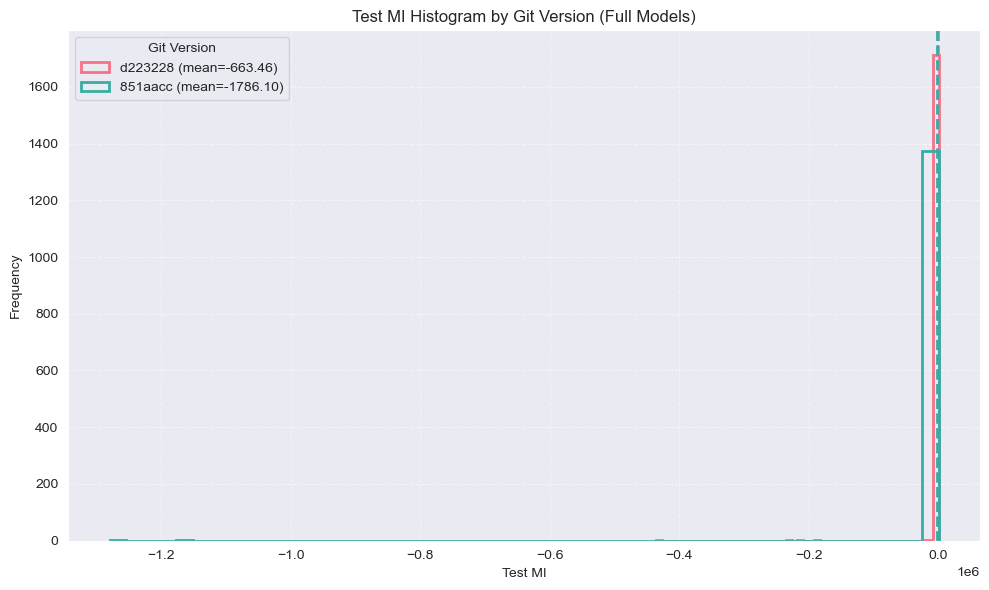

In [49]:
plt.figure(figsize=(10, 6))

# Pick unique git versions
git_versions = df_full['git_version'].unique()
colors = sns.color_palette("husl", len(git_versions))  # distinct colors

# Plot unfilled histograms per git version
for git_version, color in zip(git_versions, colors):
    sub_df = df_full[df_full['git_version'] == git_version]
    plt.hist(sub_df['test_mi'], bins=50, histtype='step', linewidth=2,
             label=f'{git_version} (mean={sub_df["test_mi"].mean():.2f})', color=color)
    mean_corr = sub_df['test_mi'].mean()
    plt.axvline(mean_corr, color=color, linestyle='--', linewidth=2)
# Style the plot
# plt.xlim(-3,3)
plt.title('Test MI Histogram by Git Version (Full Models)')
plt.xlabel('Test MI')
plt.ylabel('Frequency')
plt.legend(title='Git Version')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [44]:
df_full['git_version'].unique()

array(['with prop_whisker_rewarded'], dtype=object)

In [45]:
git_versions

array(['without prop_whisker_rewarded', 'with prop_whisker_rewarded'],
      dtype=object)

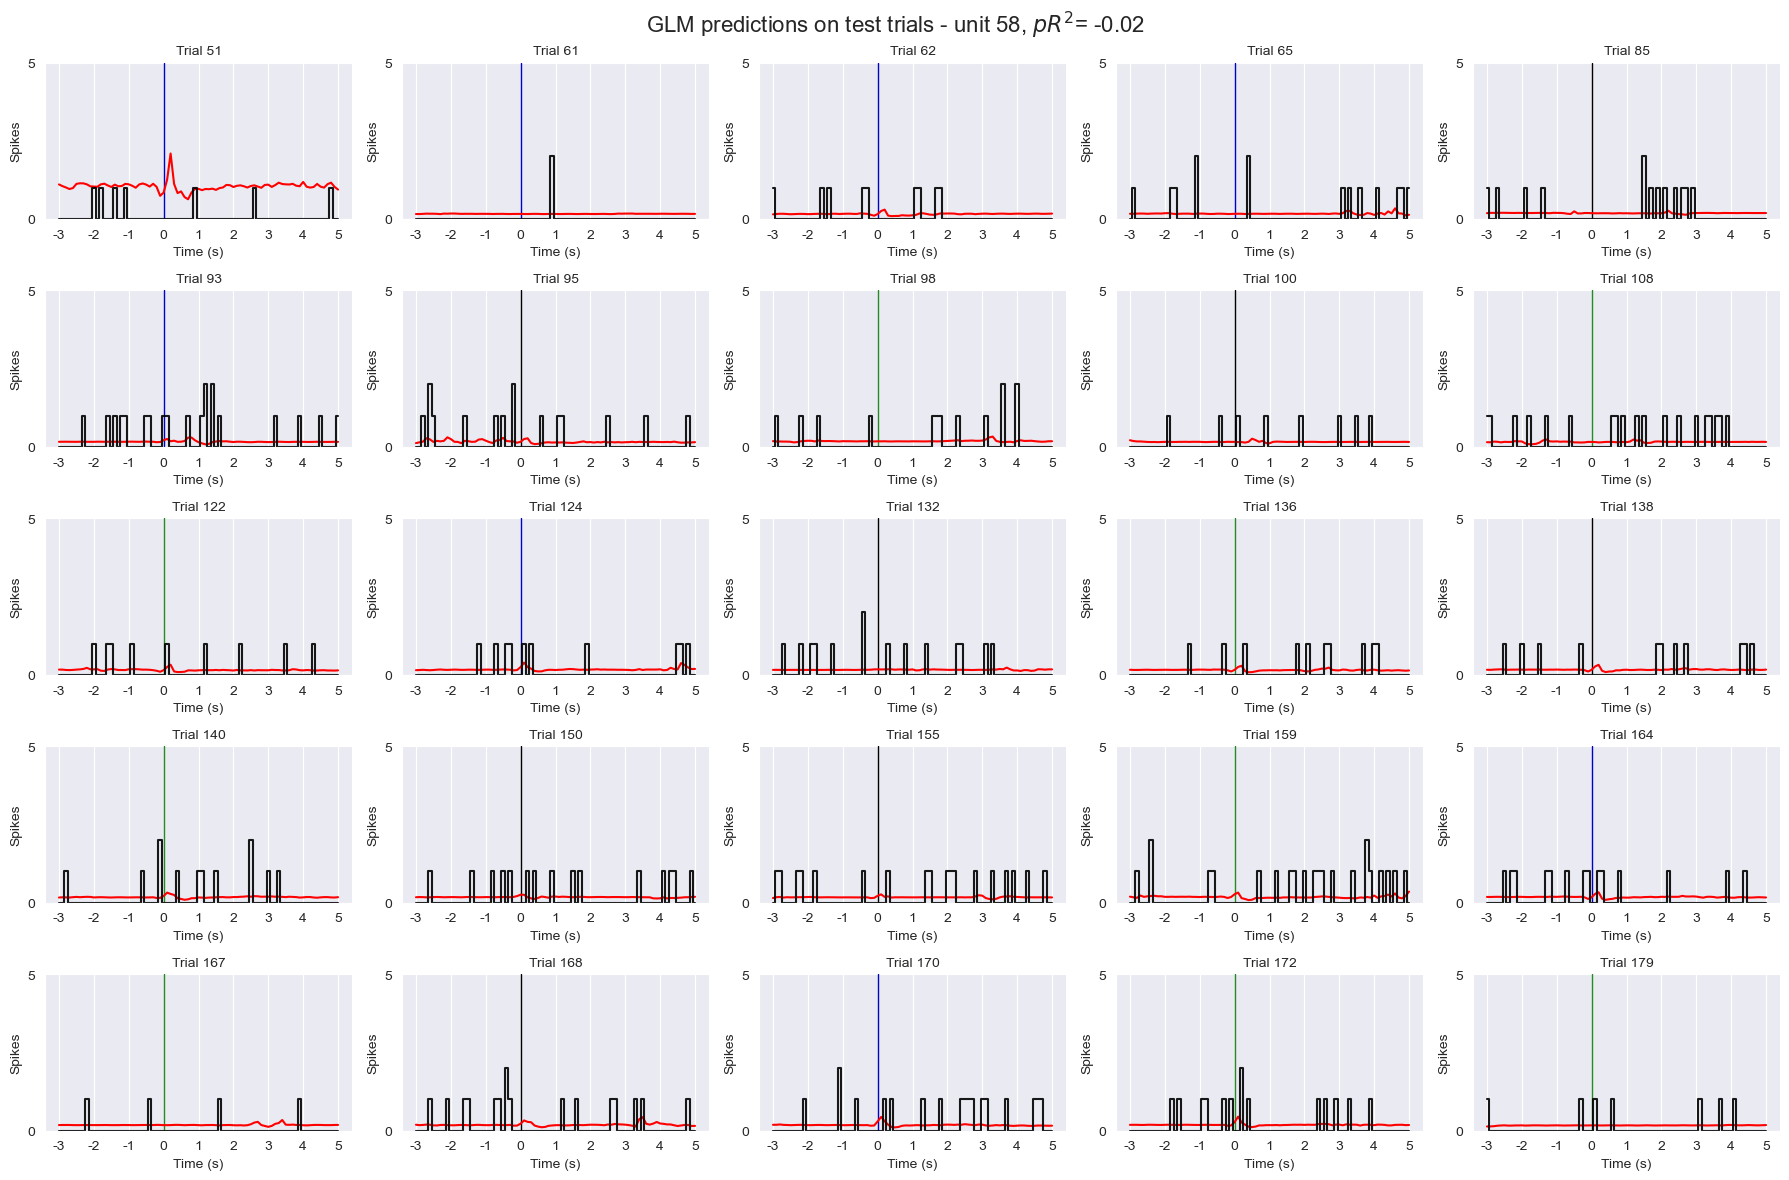

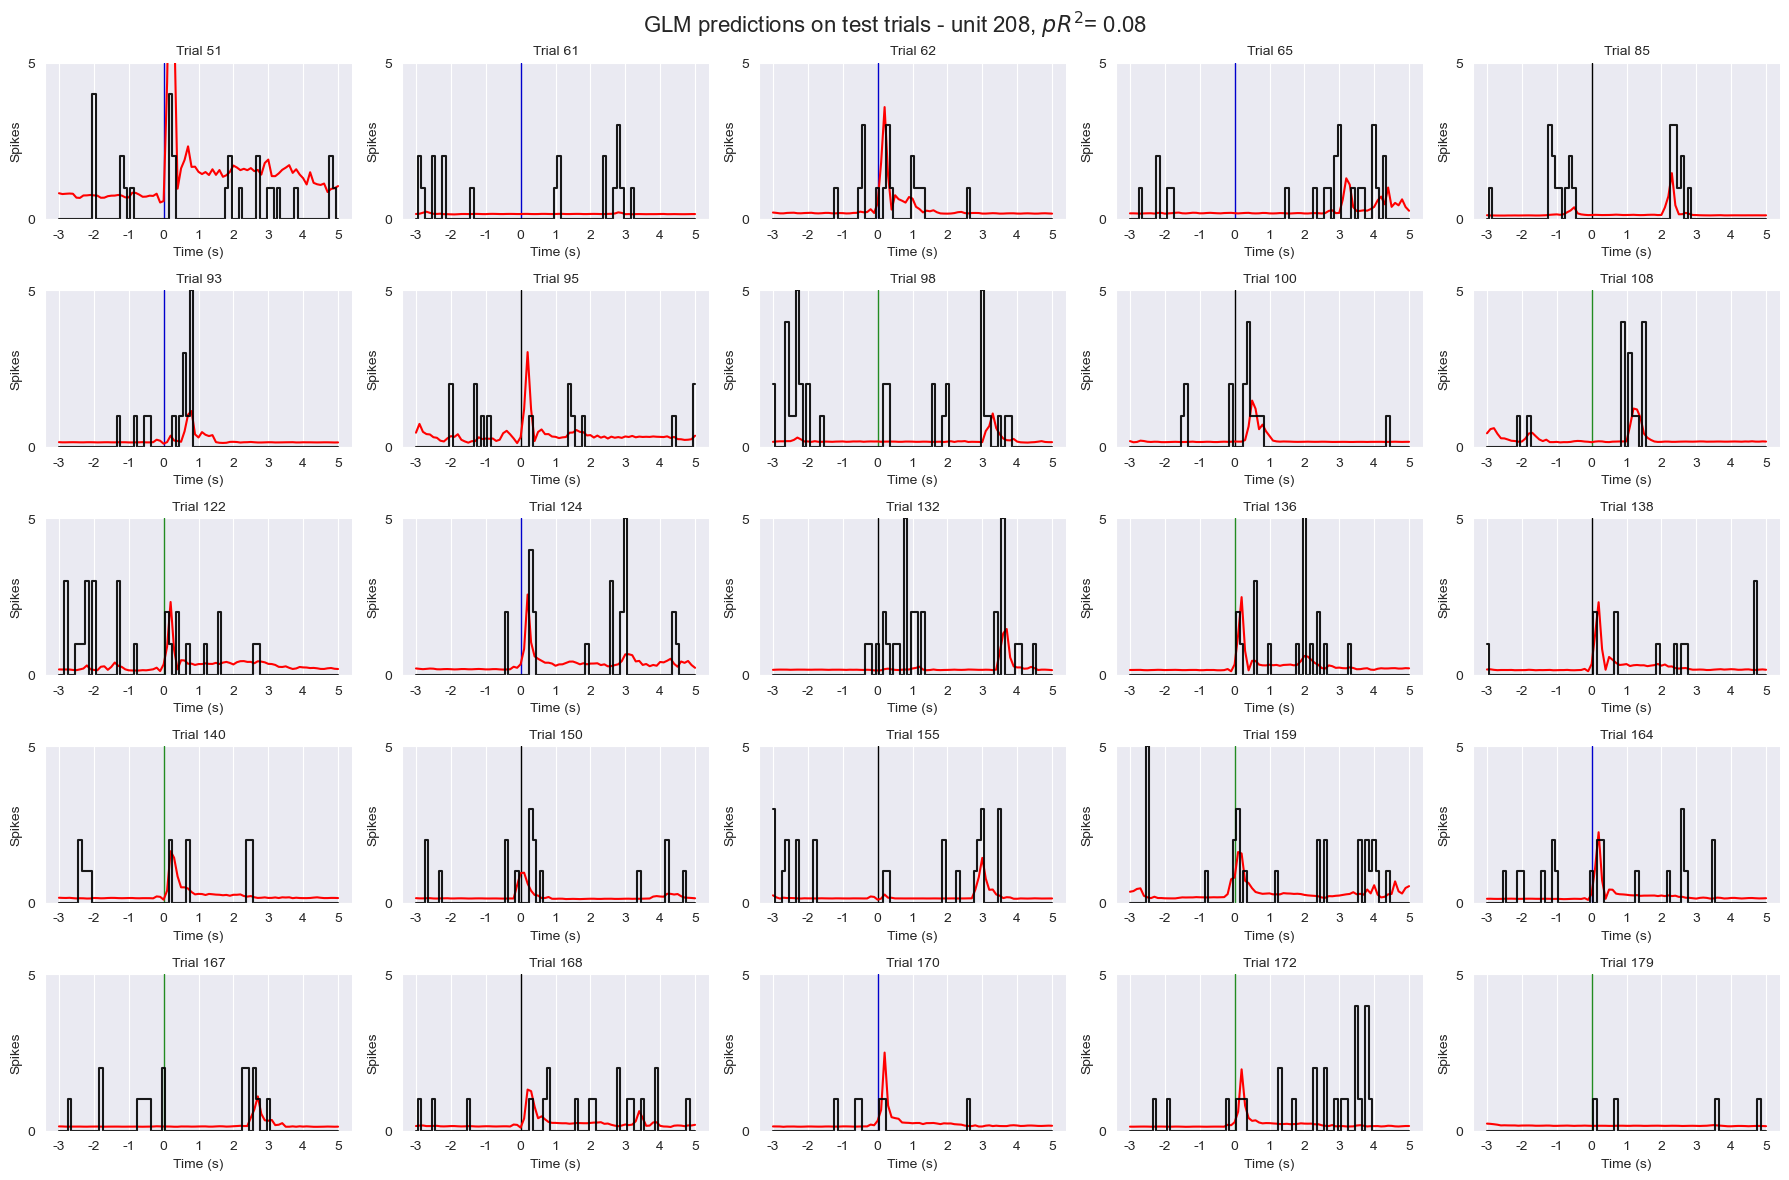

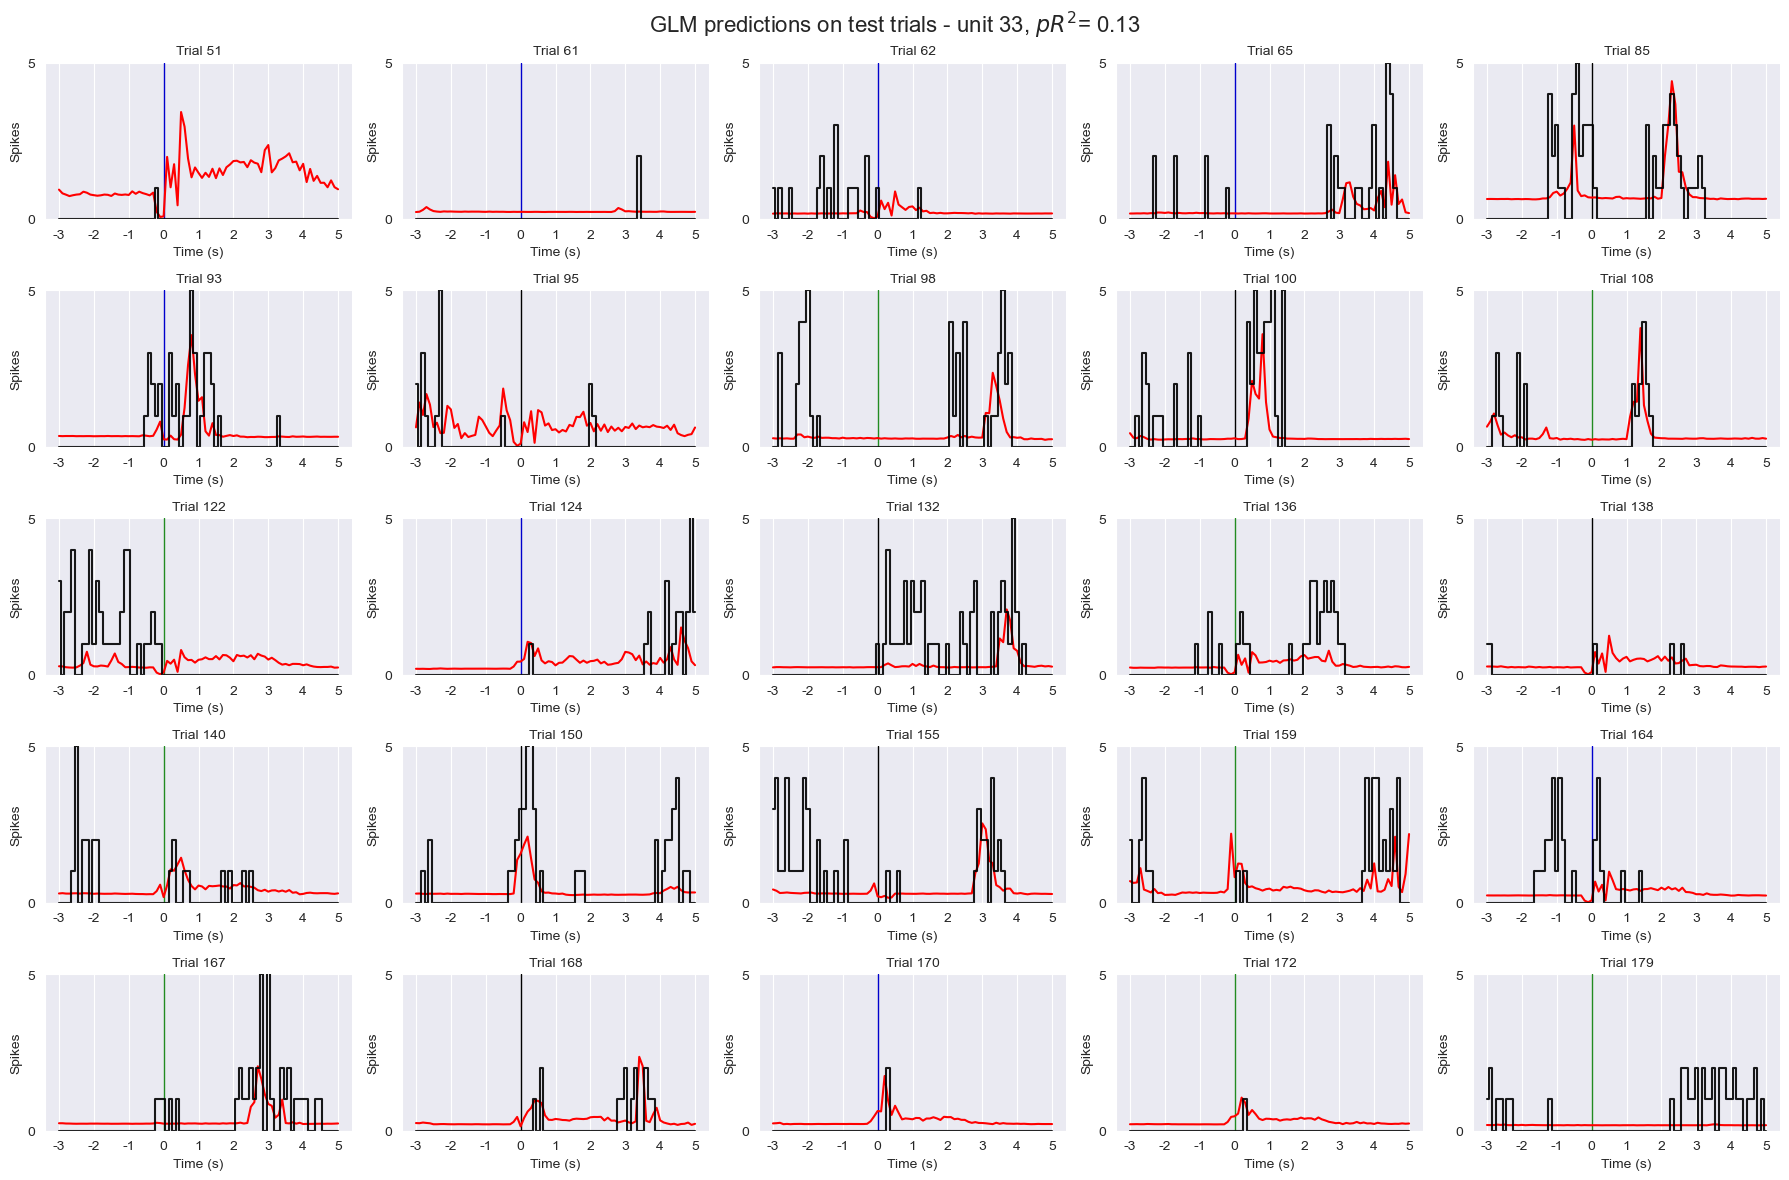

In [46]:

for neuron_id in np.random.choice(df_full.neuron_id.unique(),3):
    for git_version in ['with prop_whisker_rewarded'] :
        sub_df = df_full[df_full['git_version'] == git_version]
        glm_utils.plot_trial_grid_predictions(sub_df, trials_df, neuron_id, bin_size=0.1)


Plotting FULL model for neuron 265


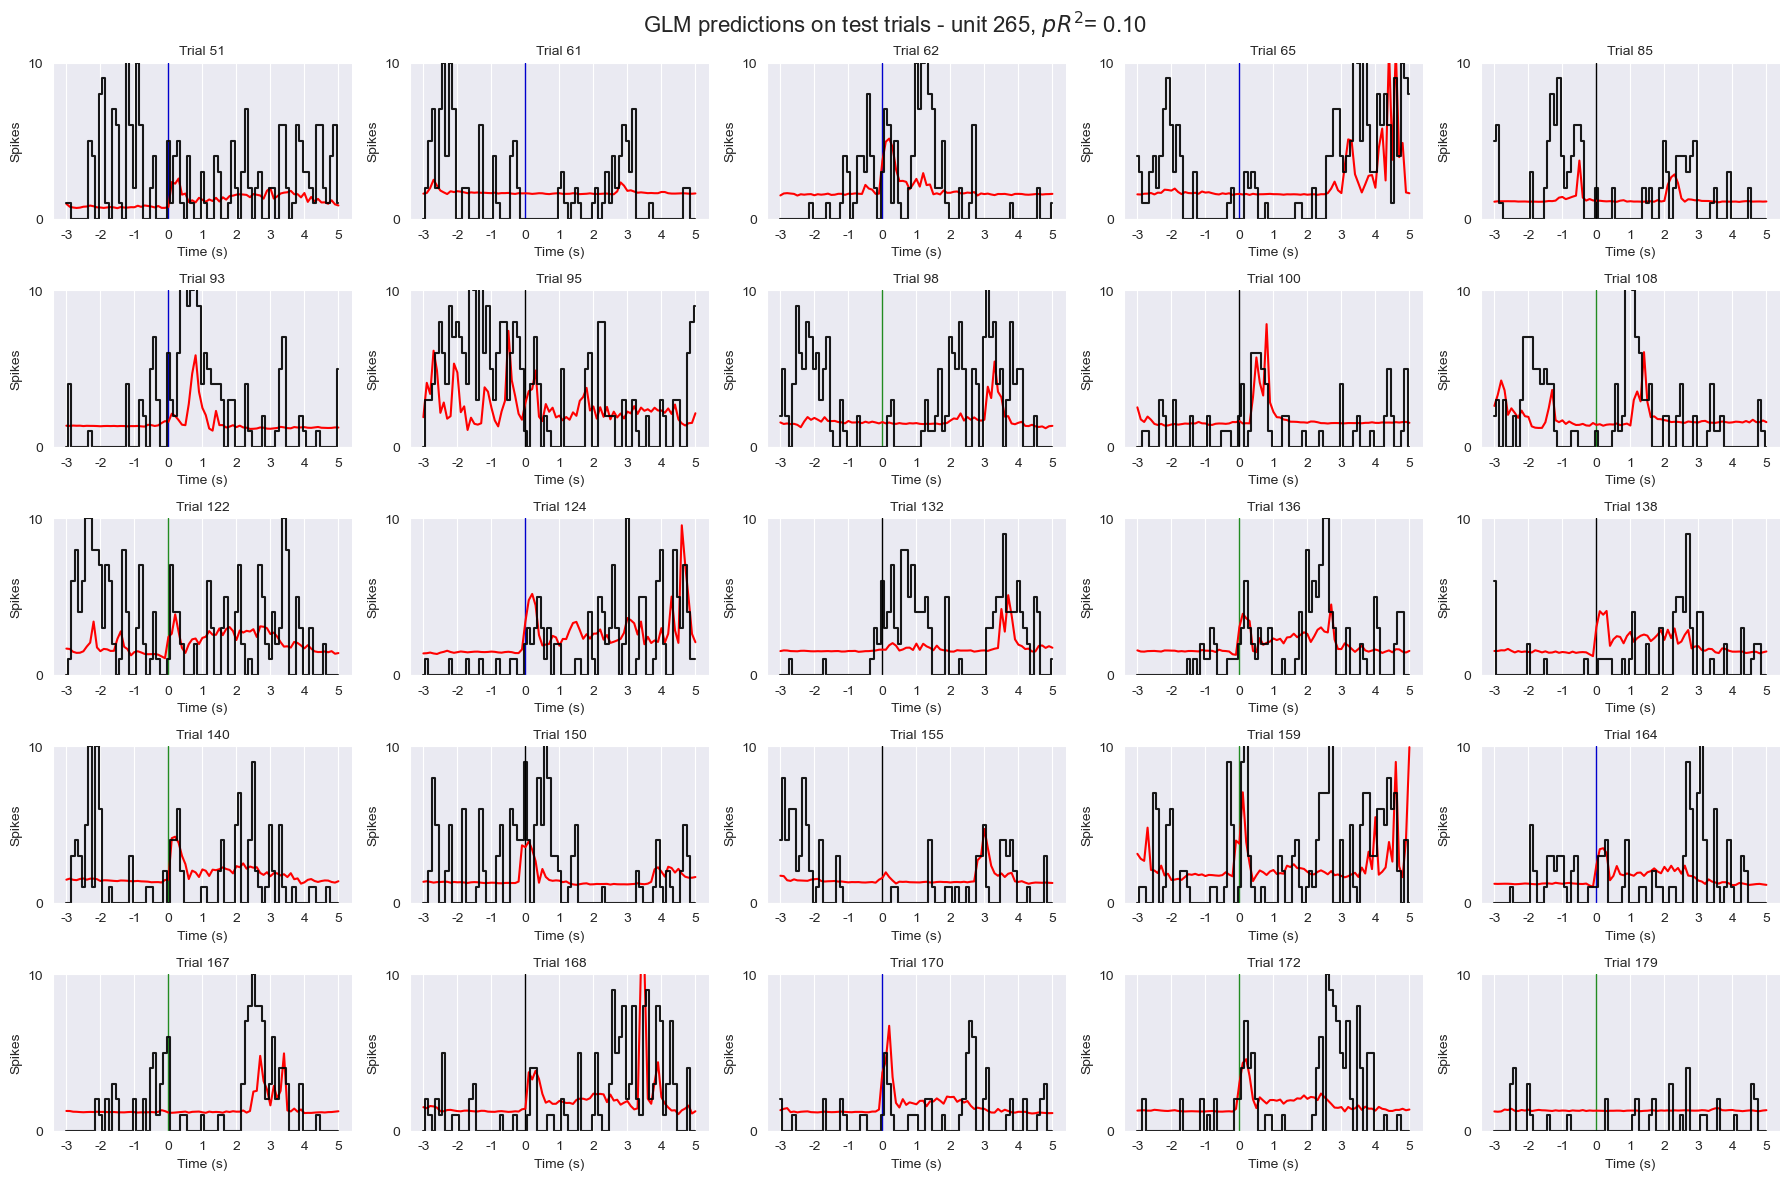

Plotting REDUCED model 'session_progress_encoding' for neuron 265


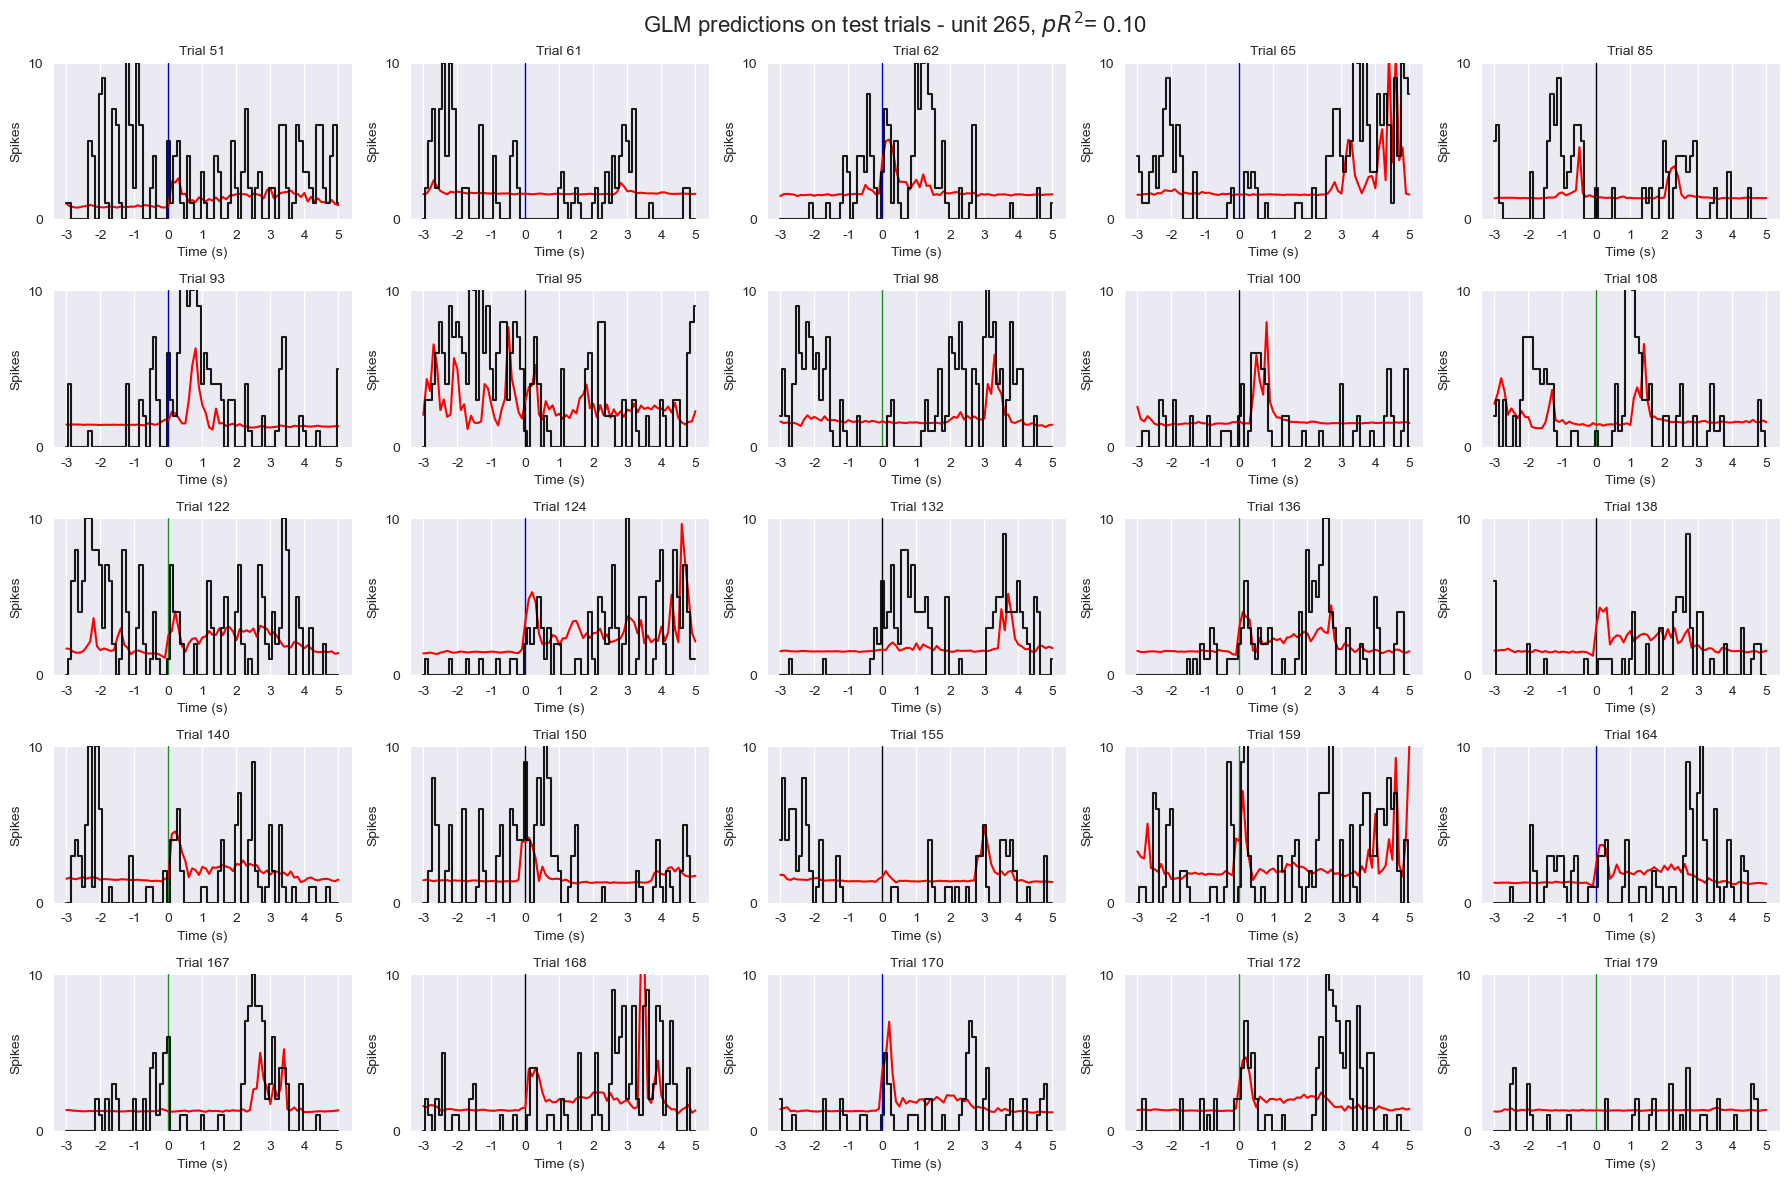

Plotting REDUCED model 'motor_encoding' for neuron 265


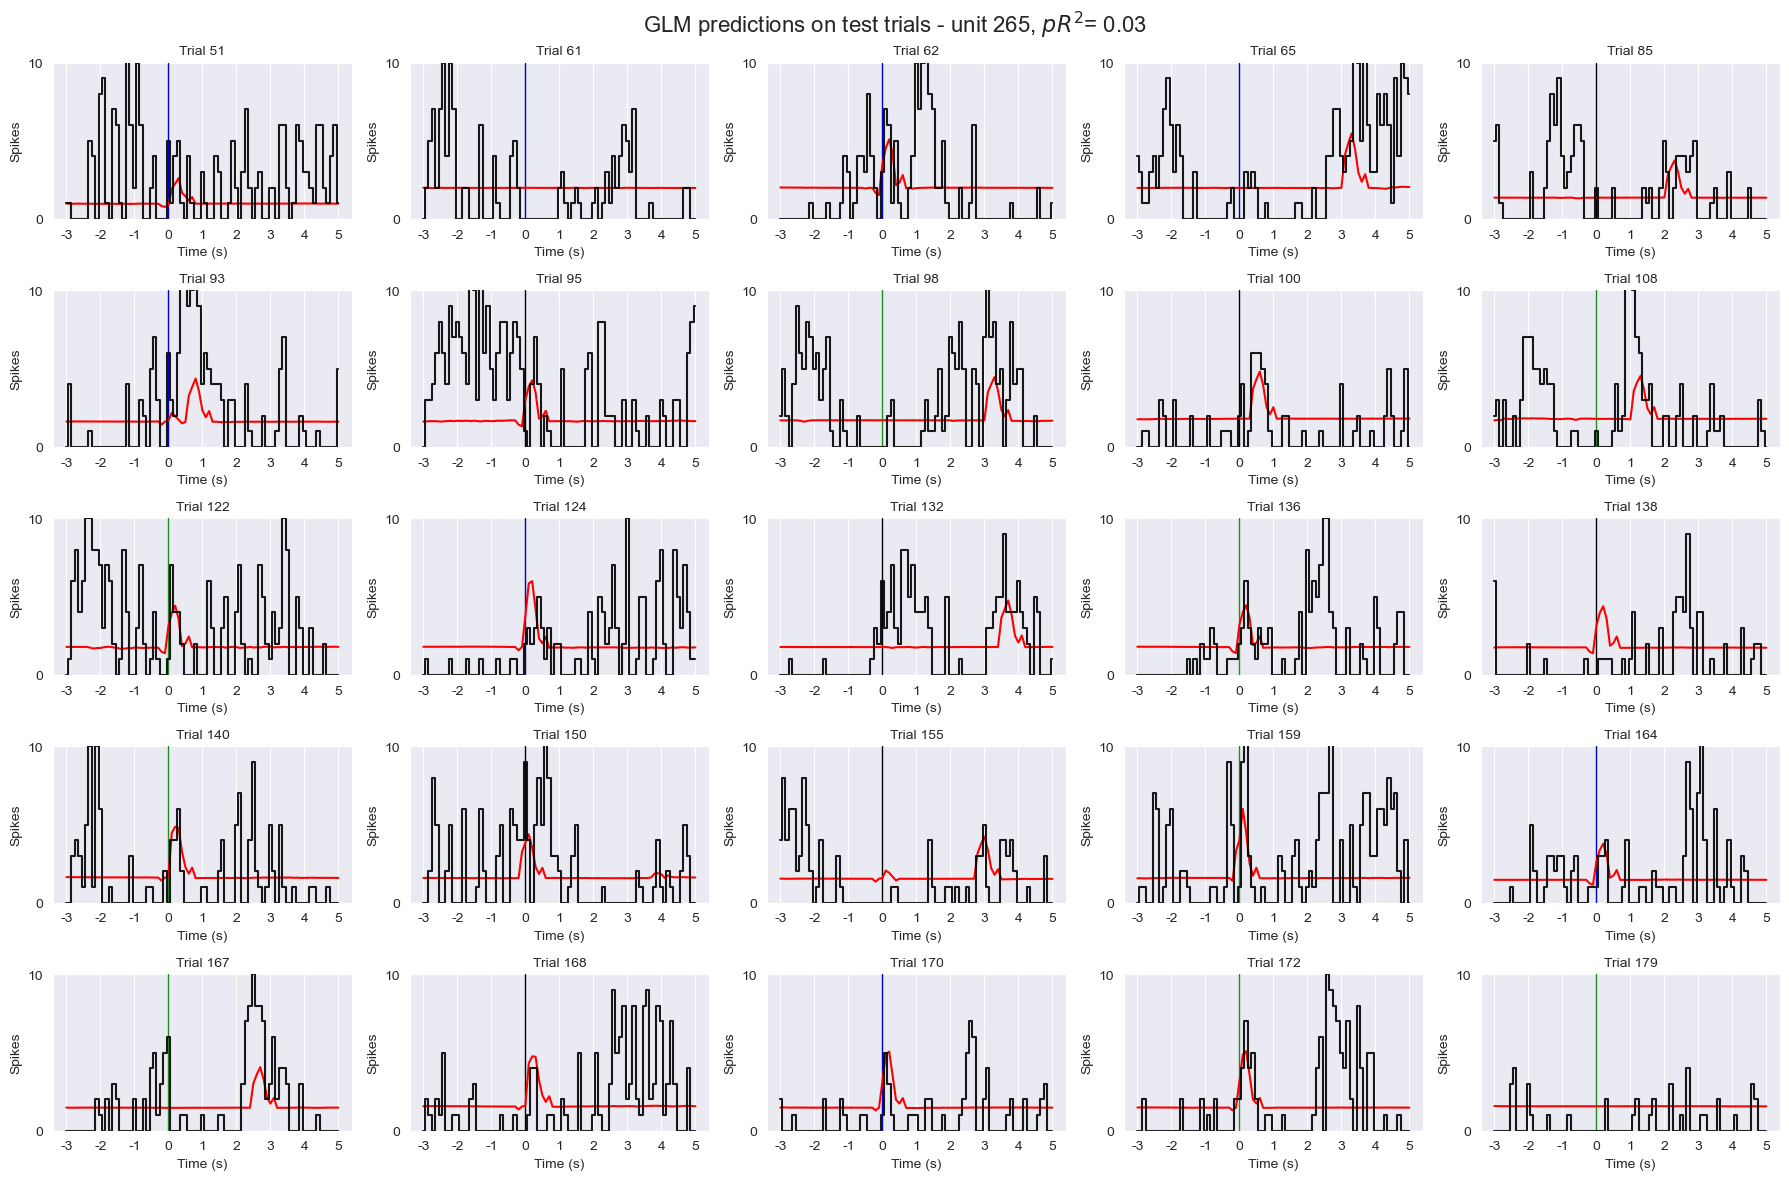


Plotting FULL model for neuron 156


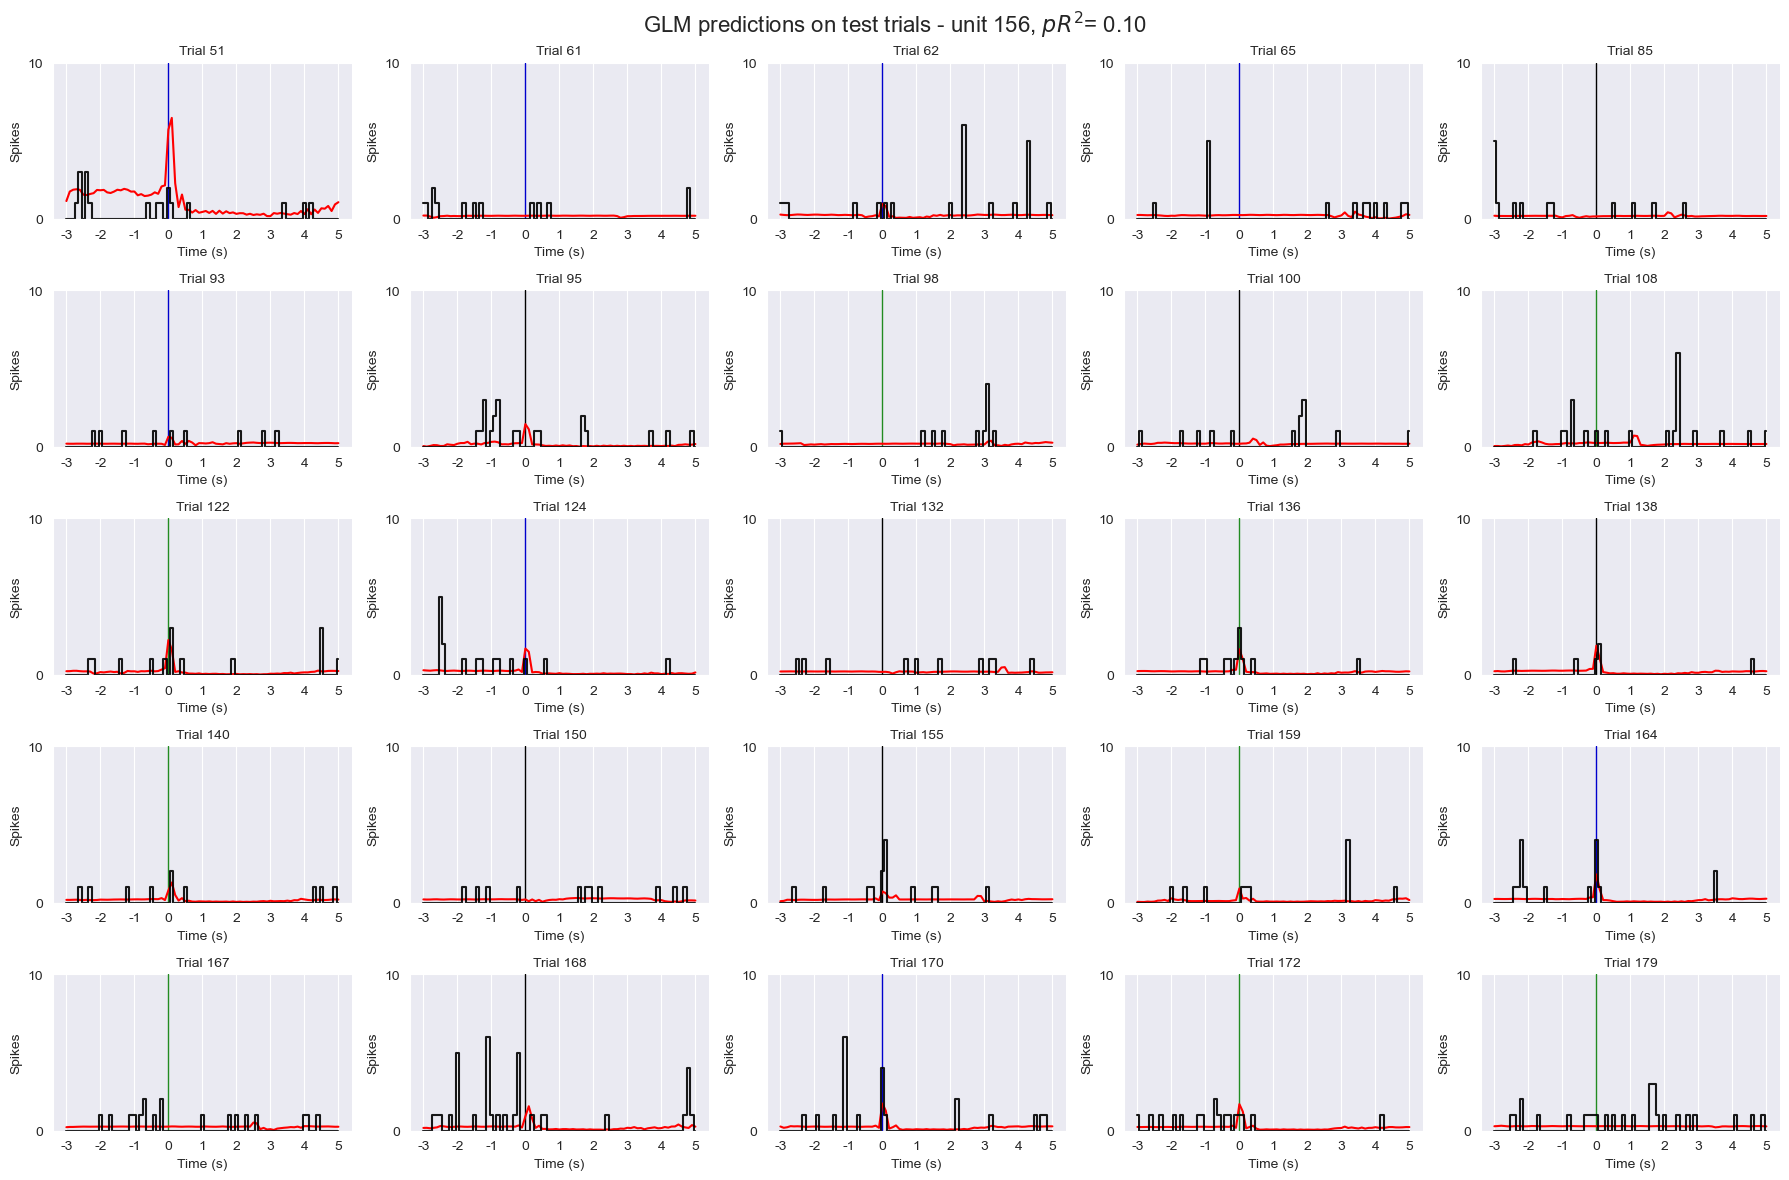

Plotting REDUCED model 'session_progress_encoding' for neuron 156


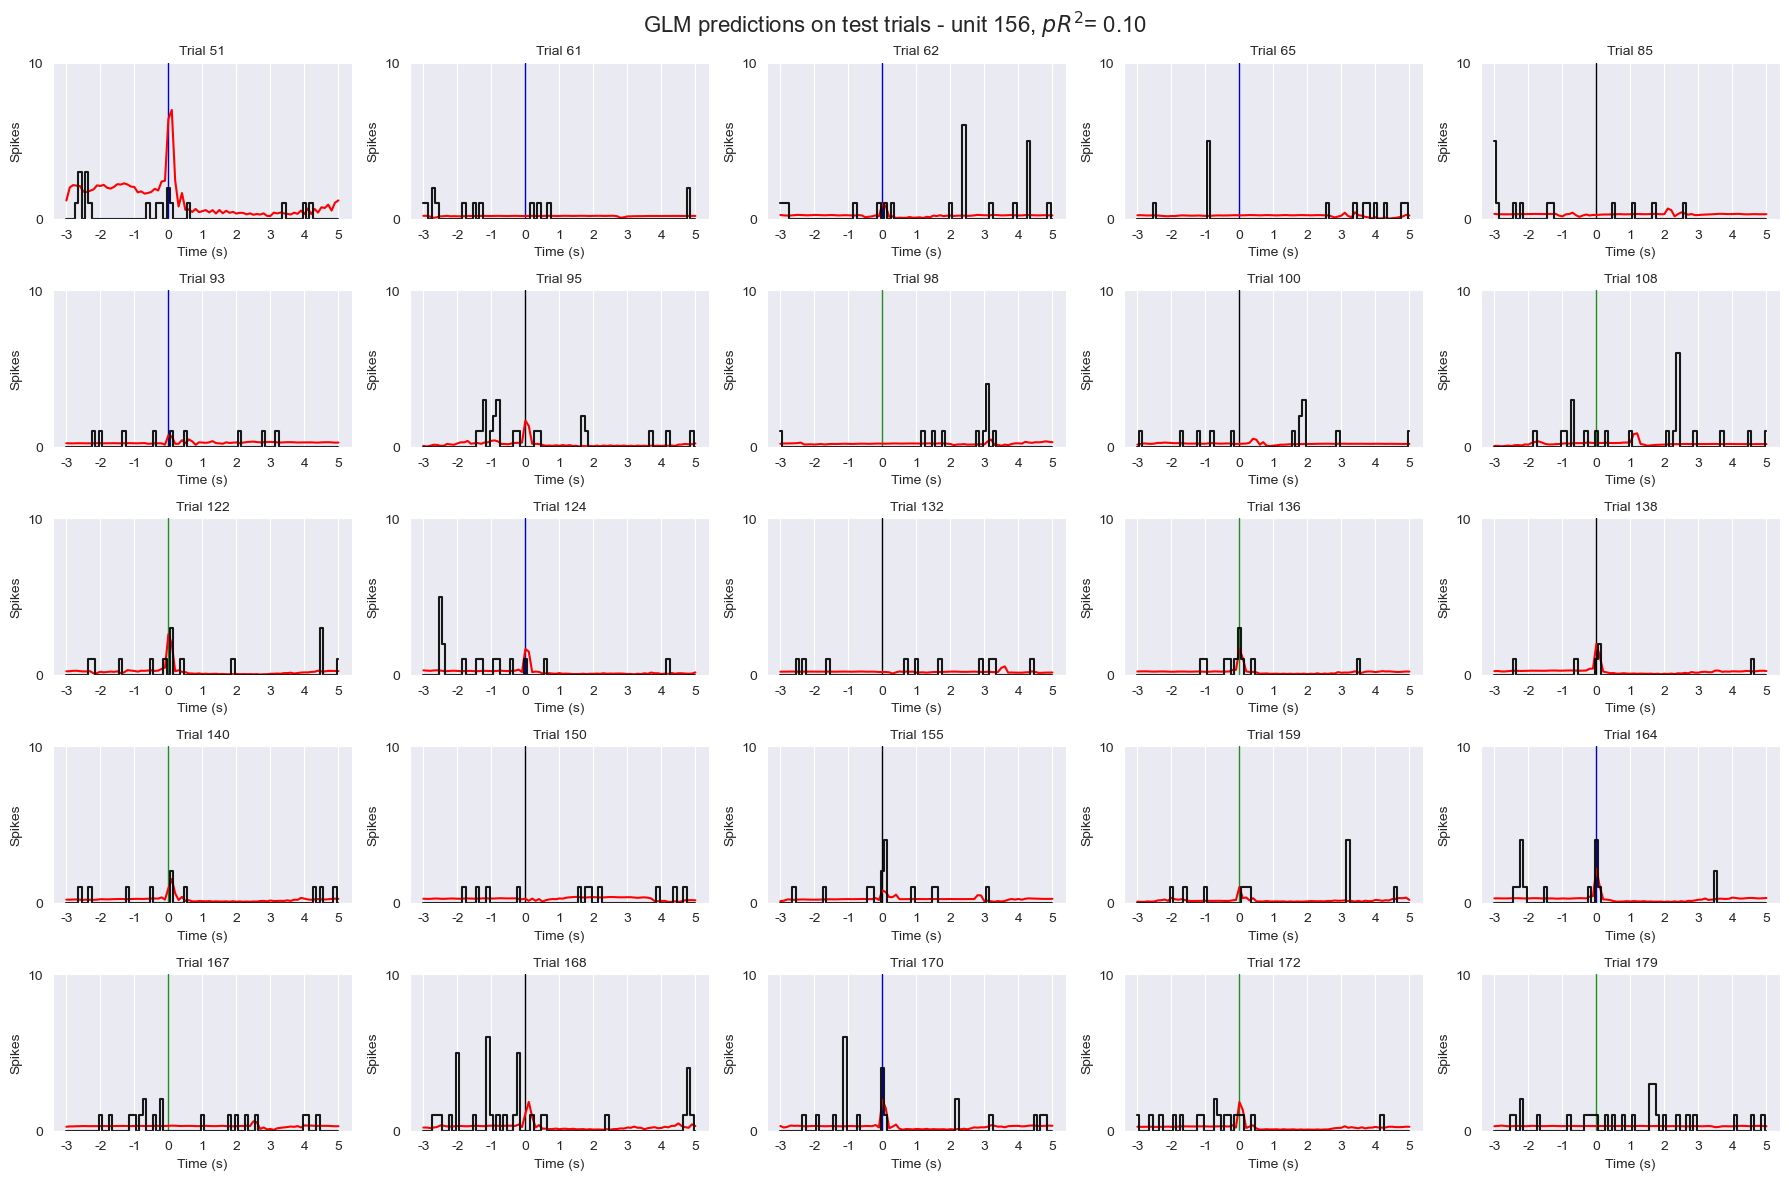

Plotting REDUCED model 'motor_encoding' for neuron 156


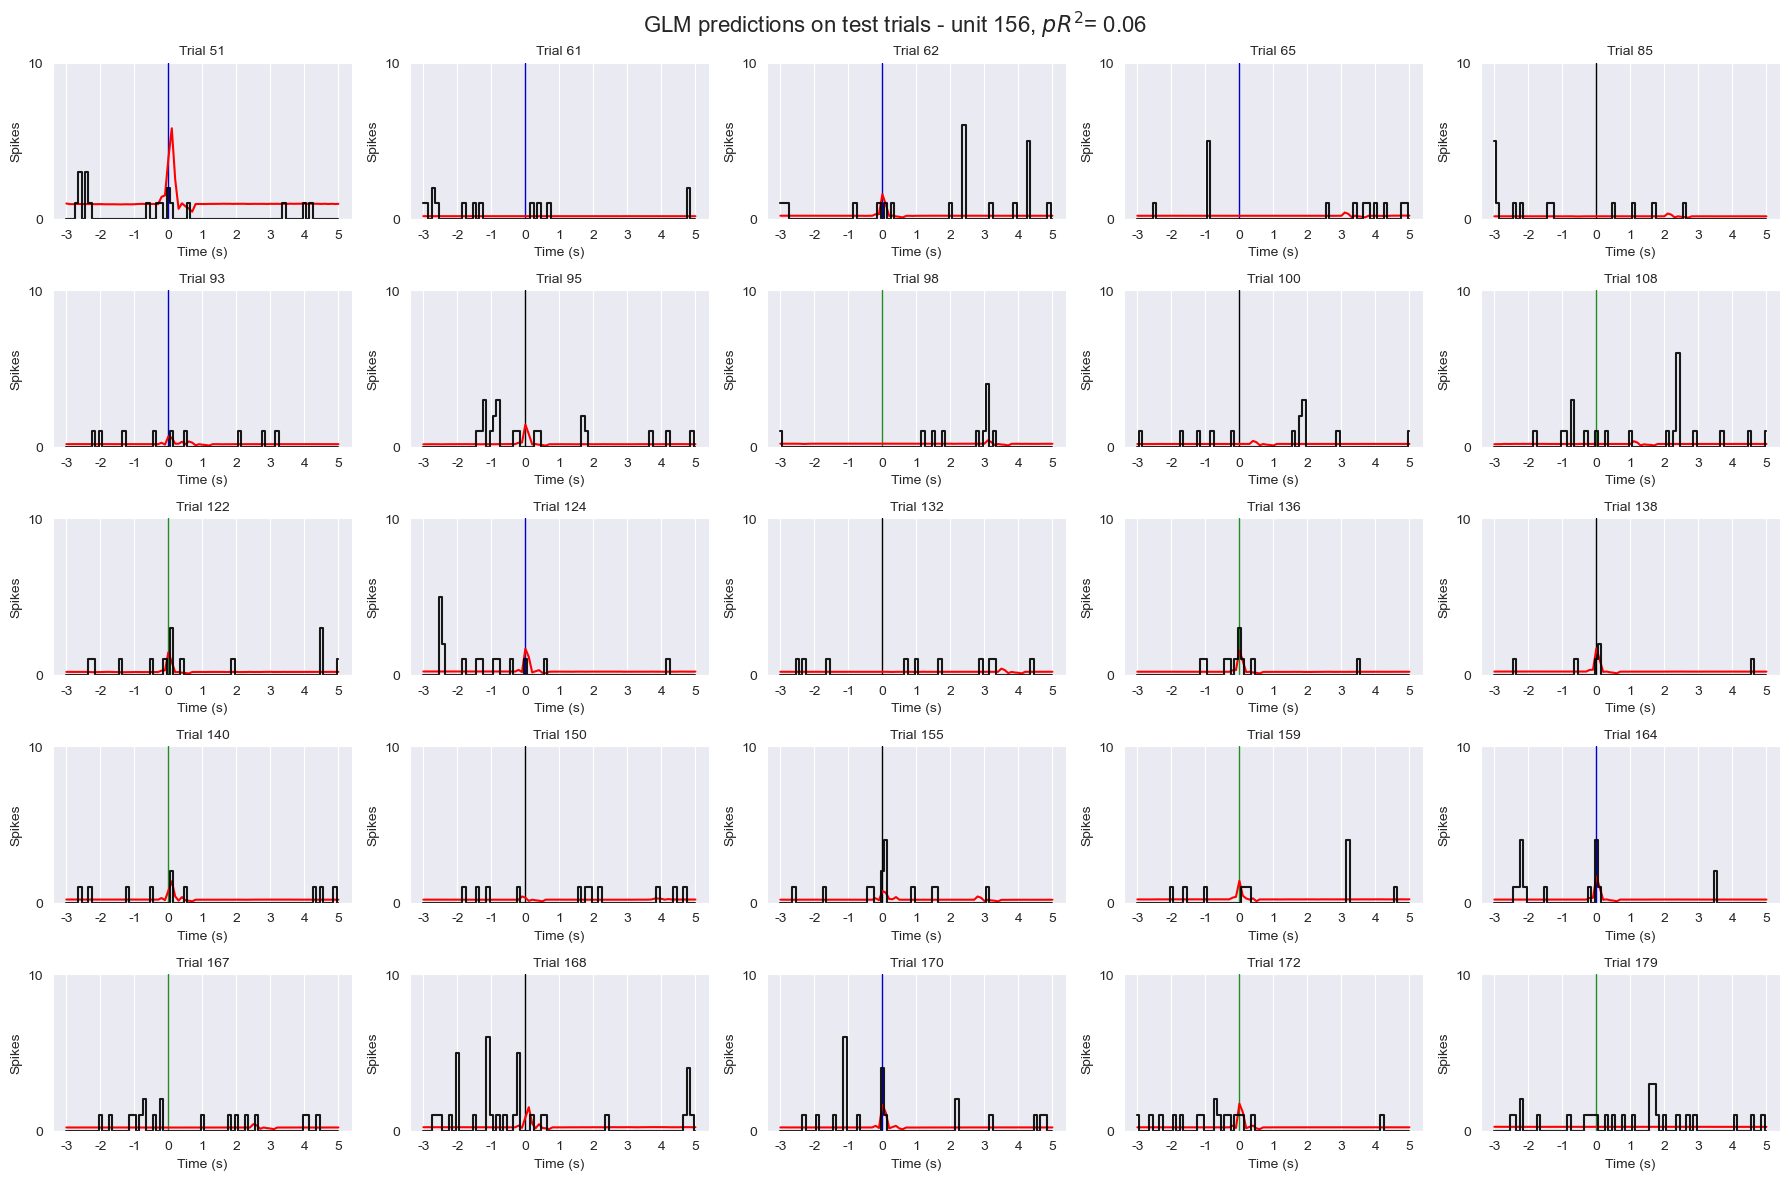


Plotting FULL model for neuron 207


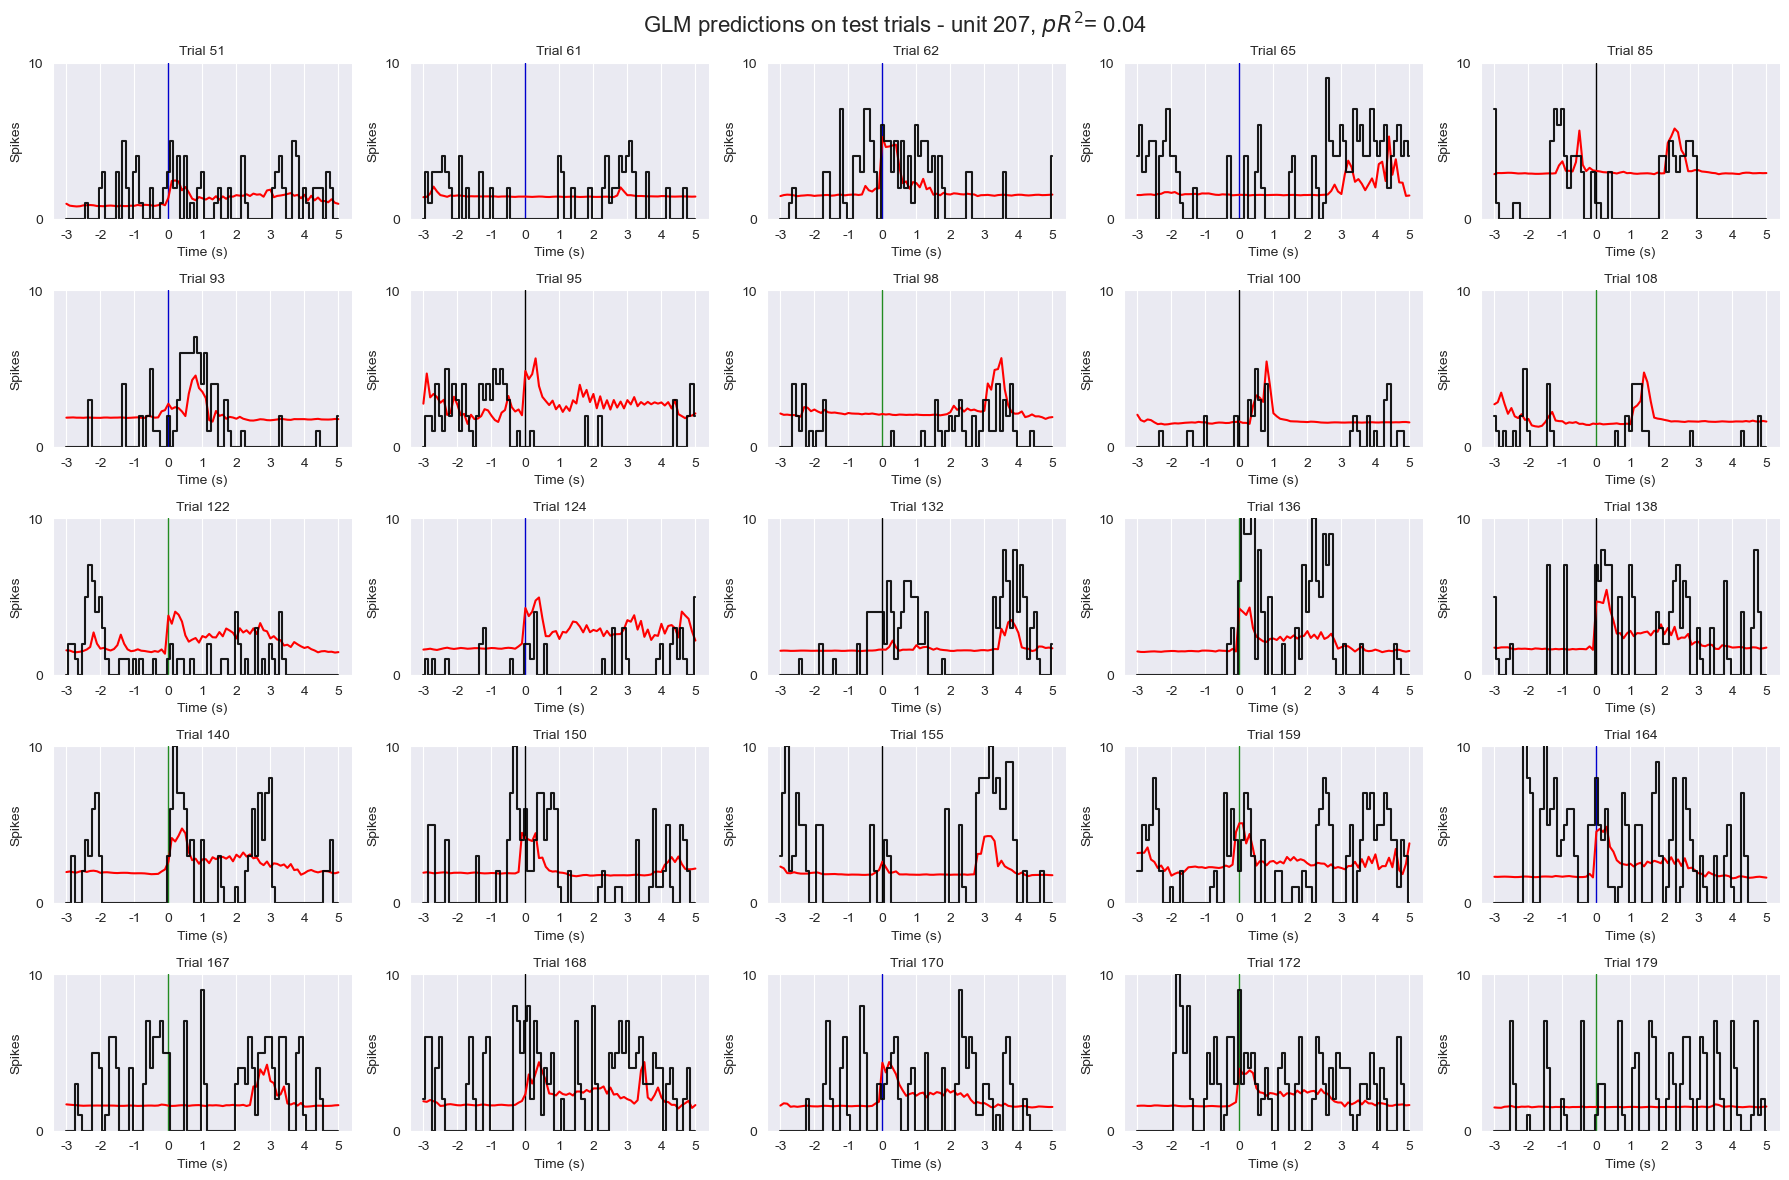

Plotting REDUCED model 'session_progress_encoding' for neuron 207


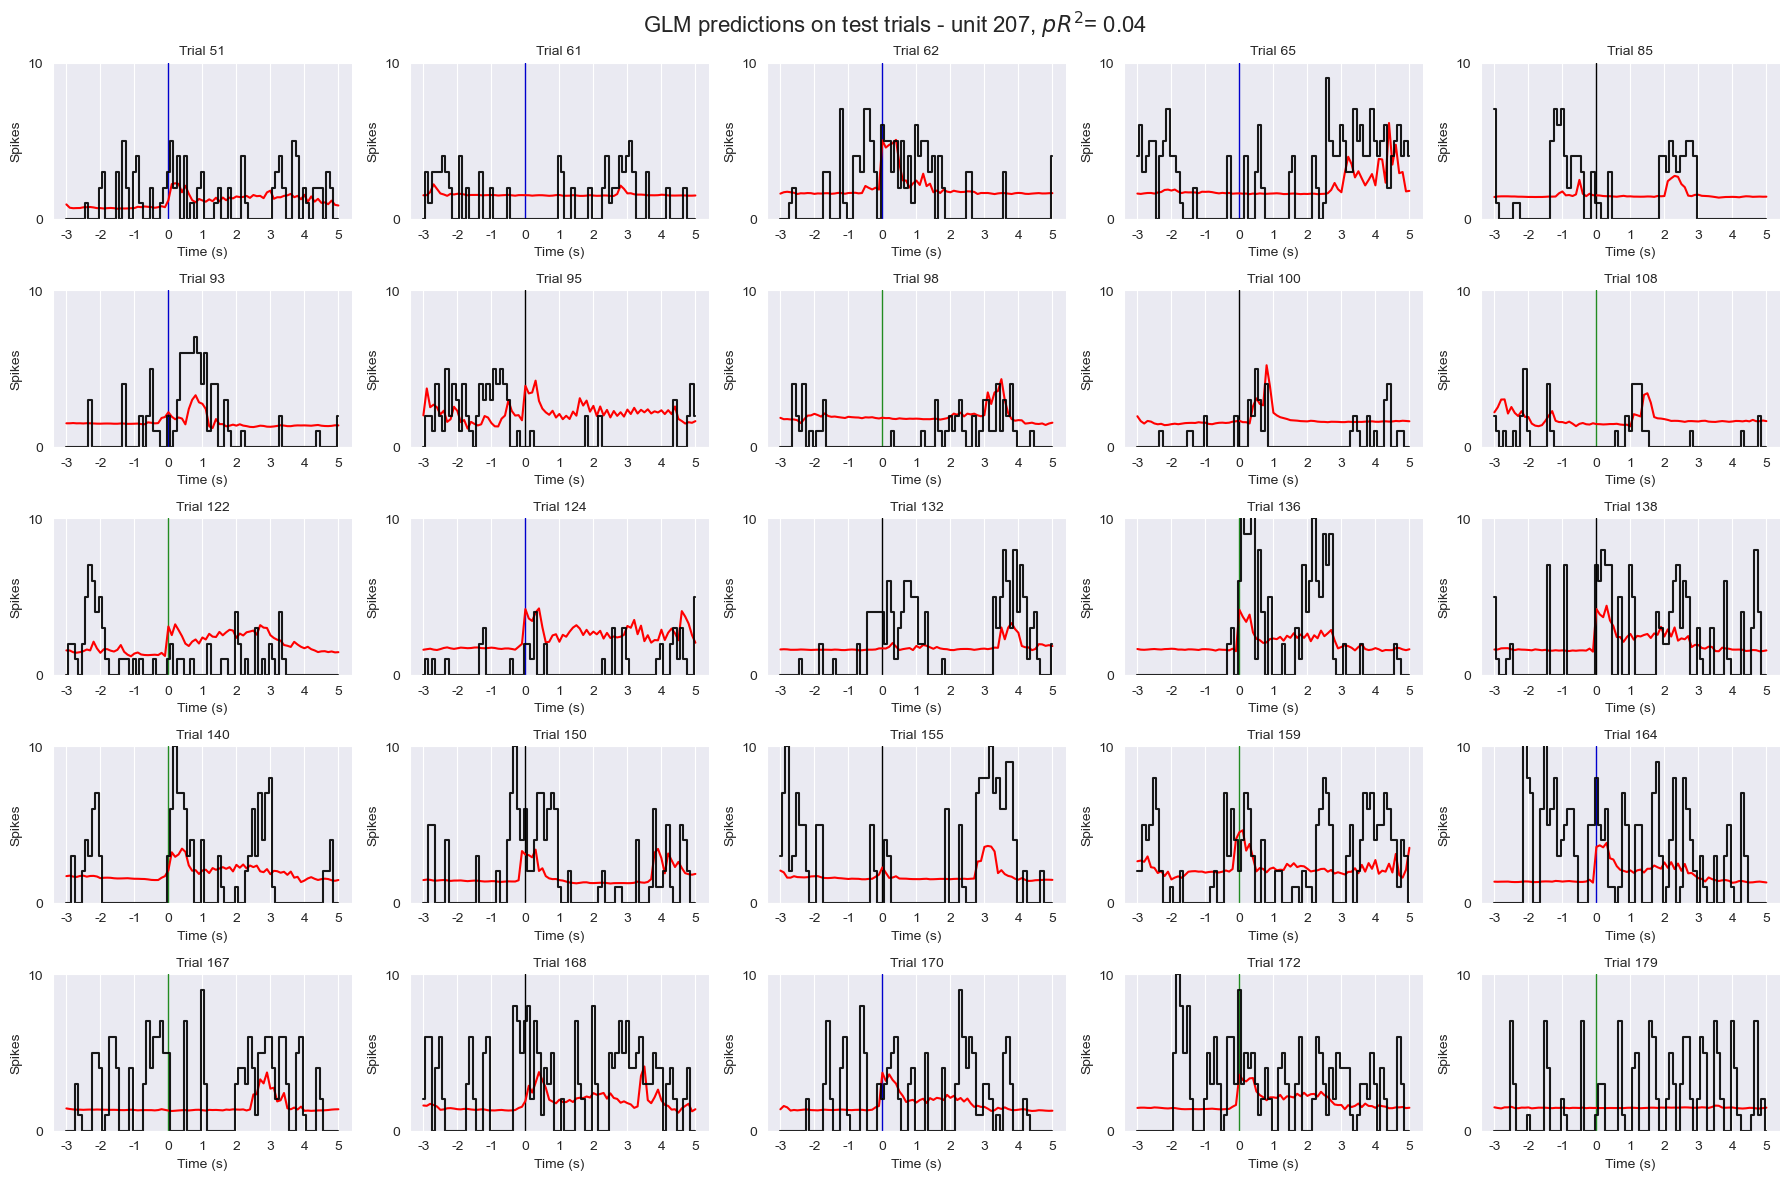

Plotting REDUCED model 'motor_encoding' for neuron 207


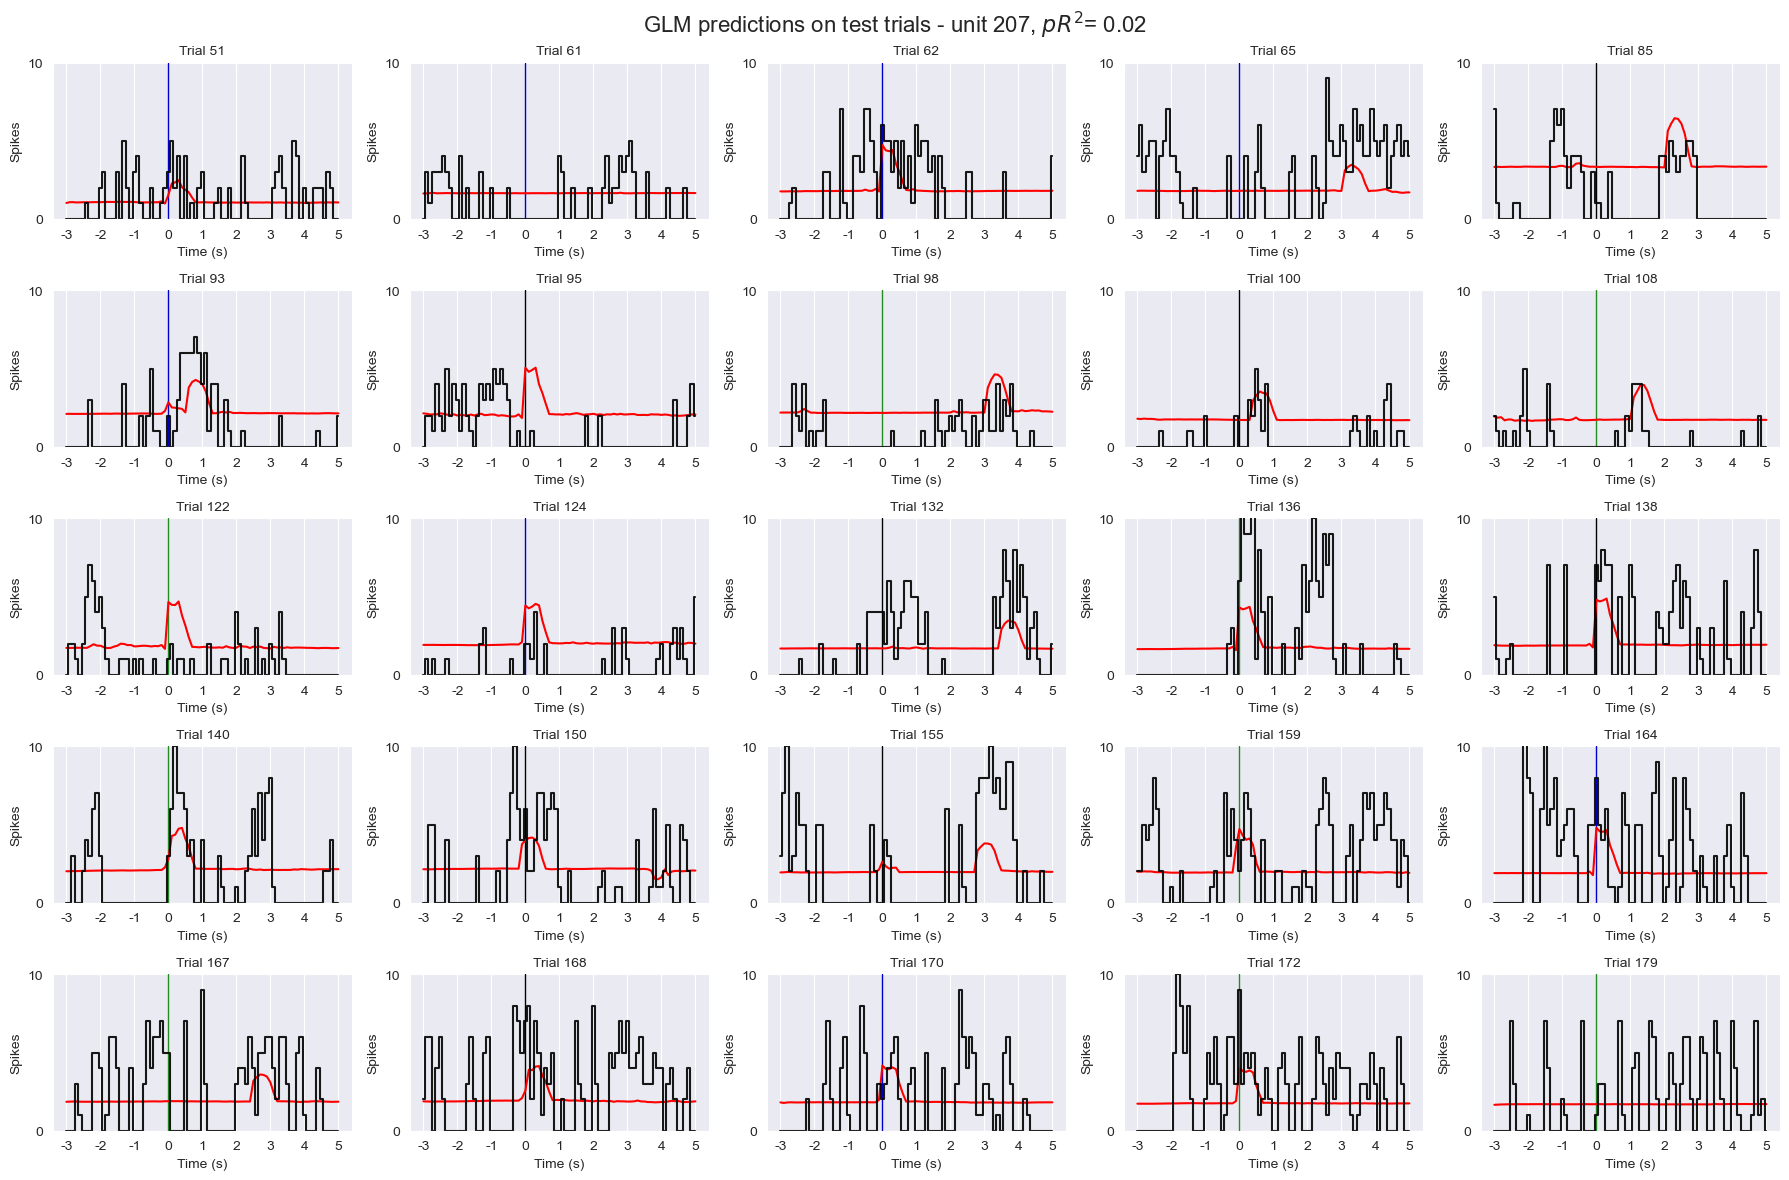


Plotting FULL model for neuron 244


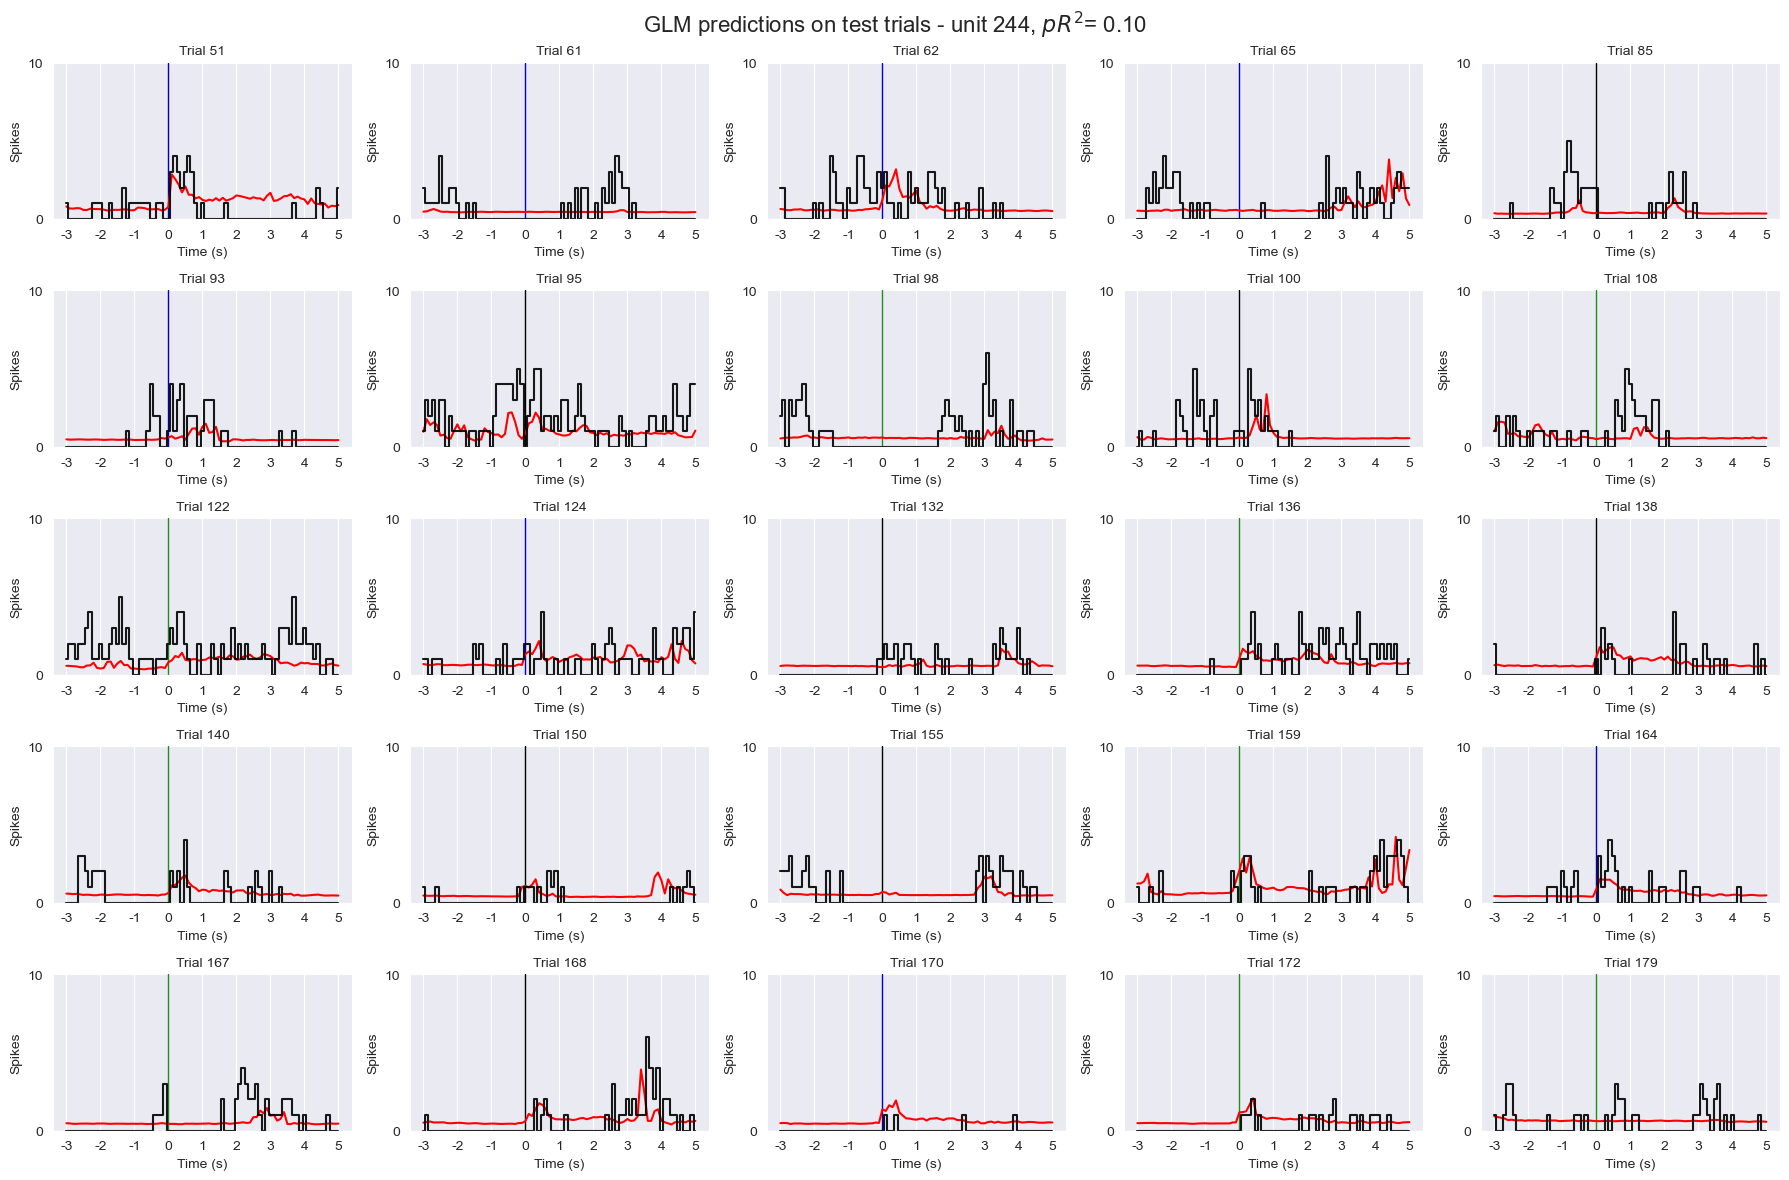

Plotting REDUCED model 'session_progress_encoding' for neuron 244


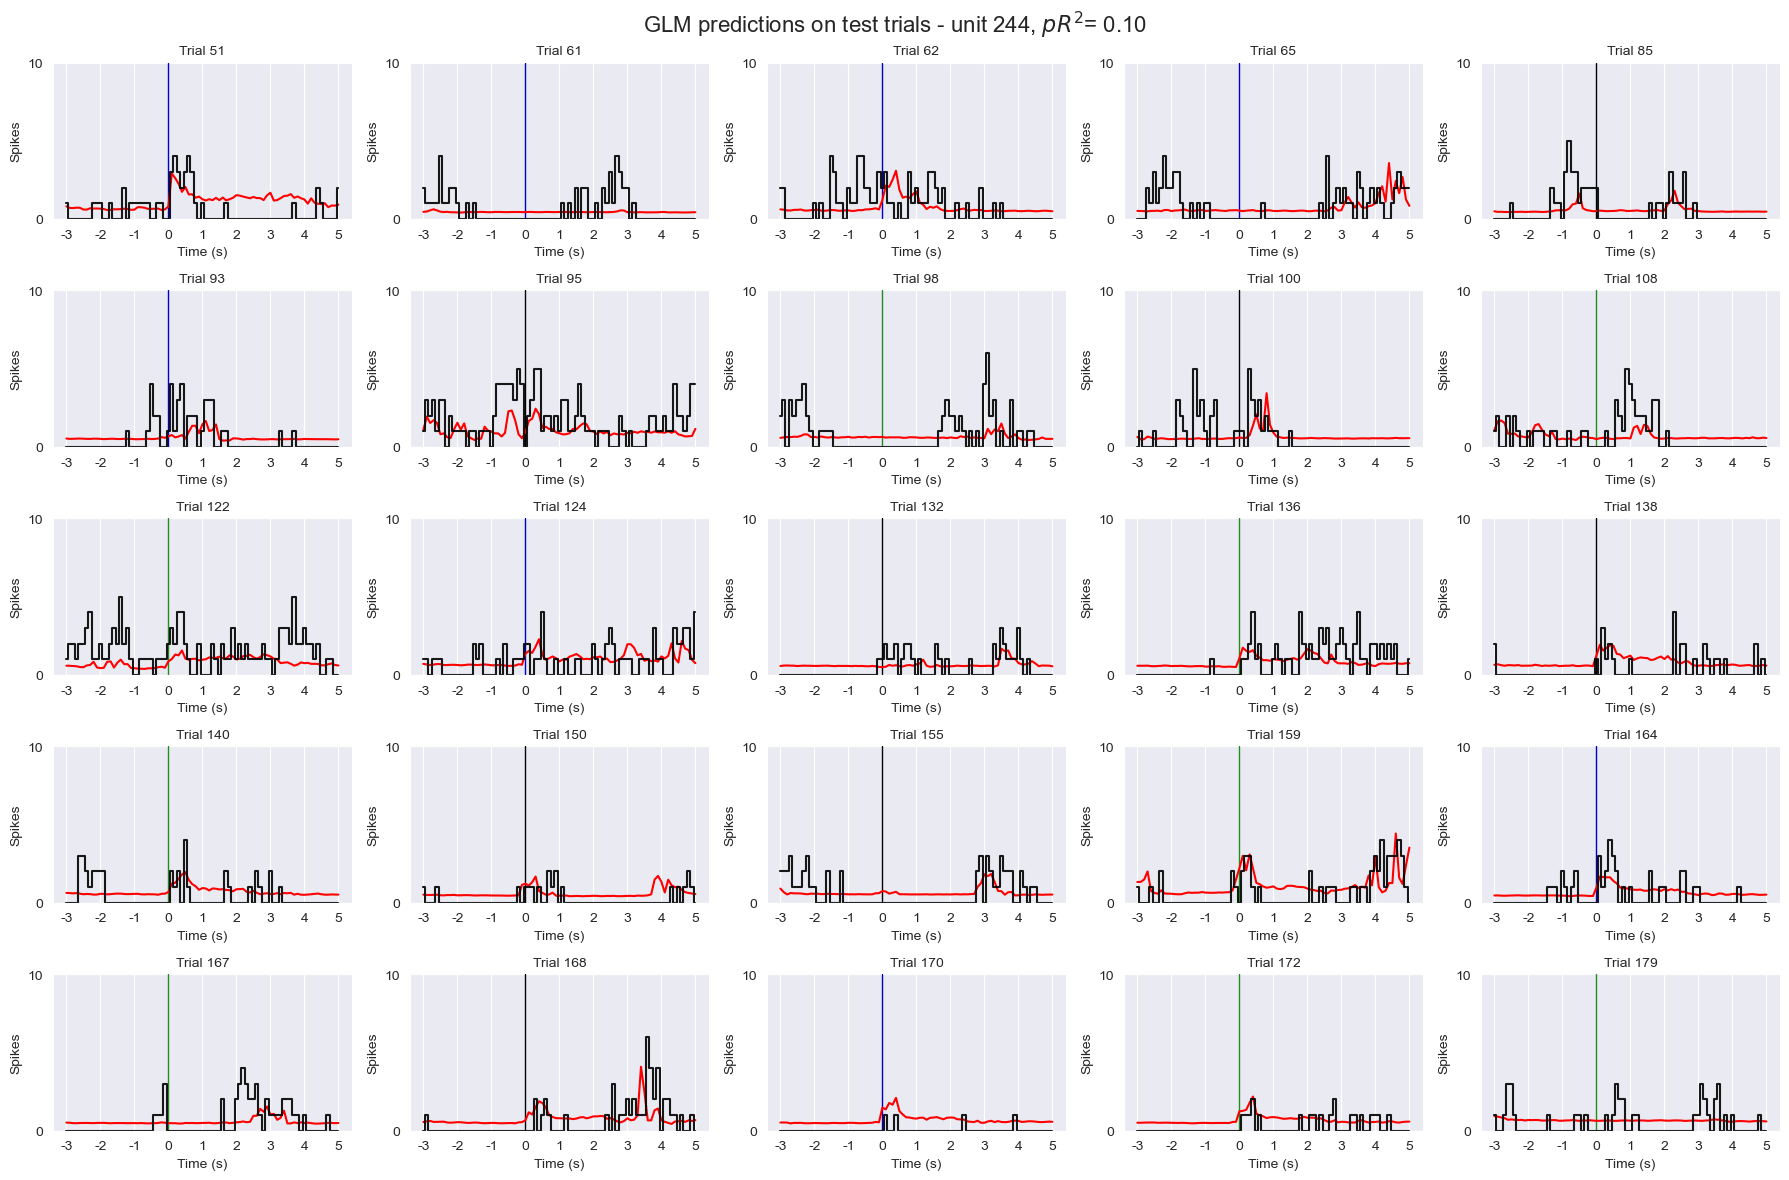

Plotting REDUCED model 'motor_encoding' for neuron 244


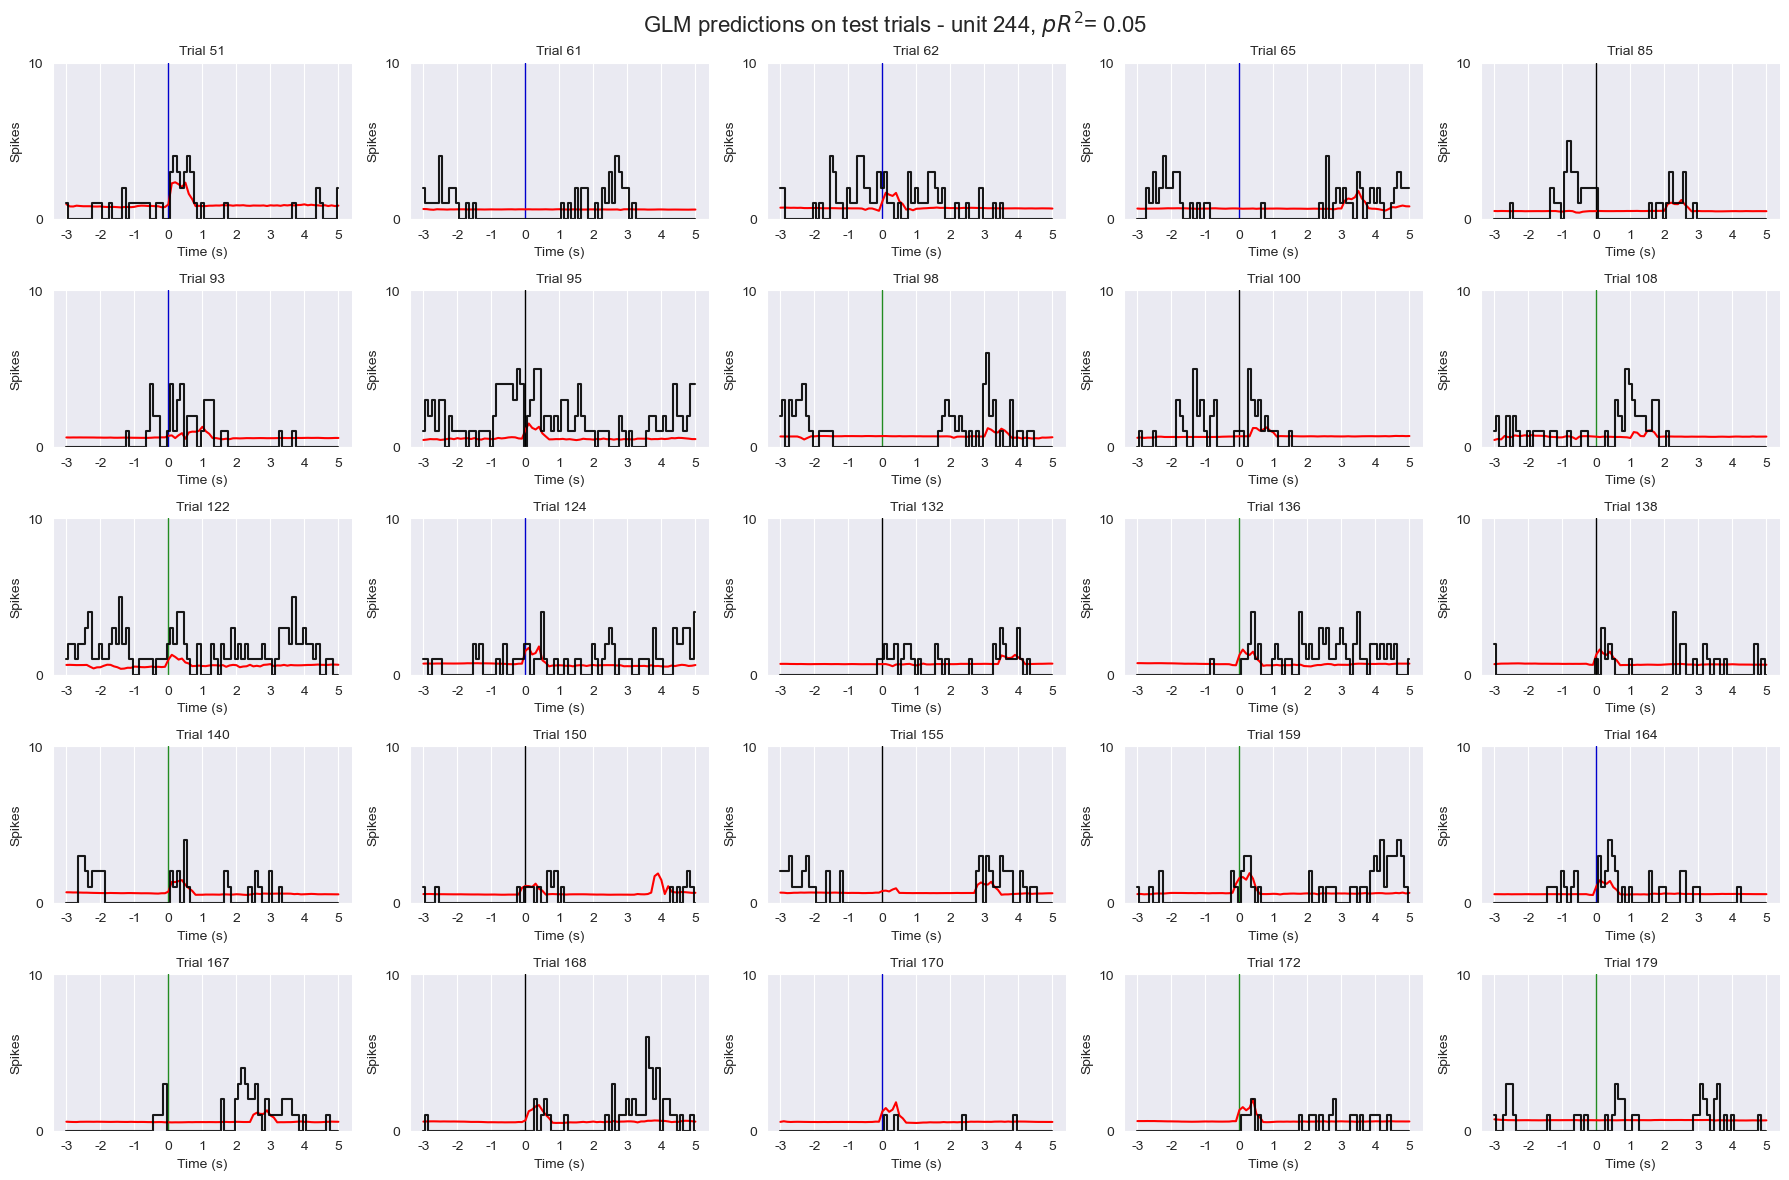


Plotting FULL model for neuron 112


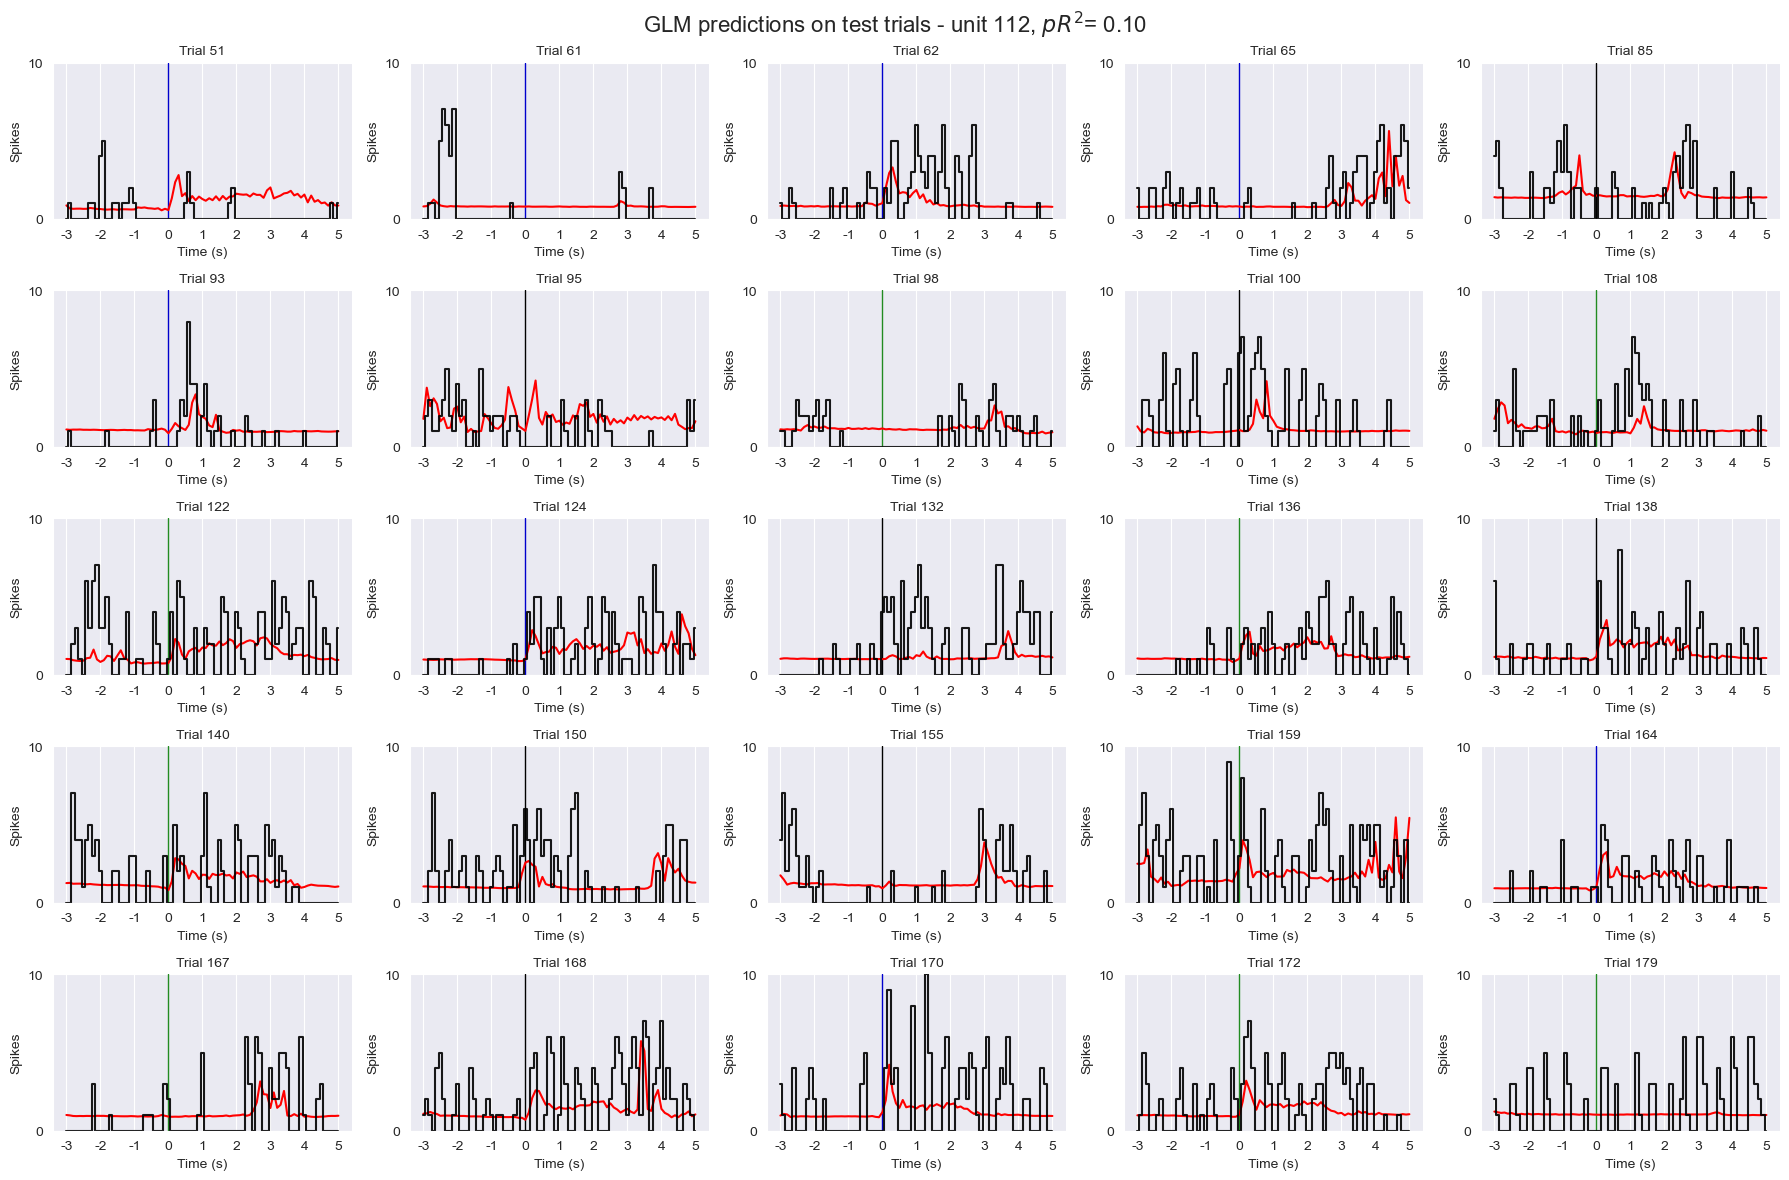

Plotting REDUCED model 'session_progress_encoding' for neuron 112


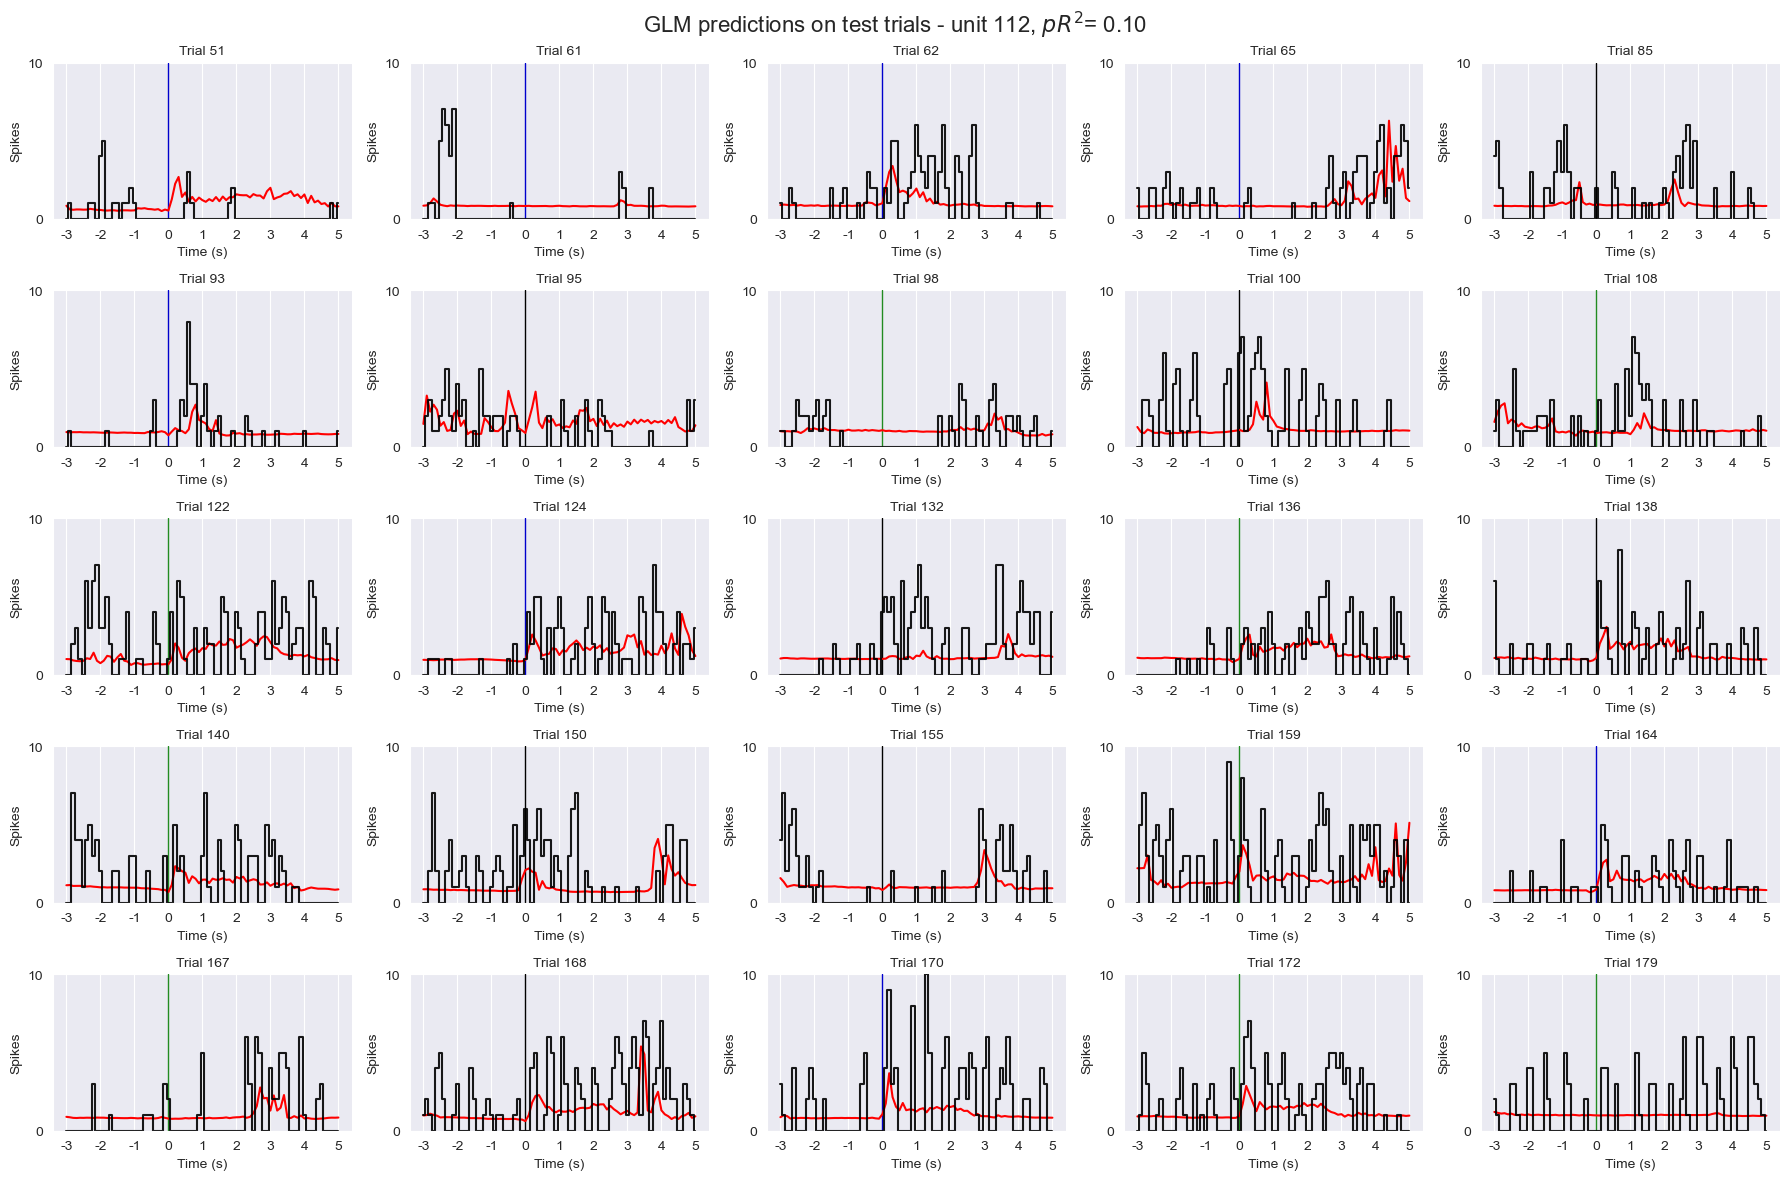

Plotting REDUCED model 'motor_encoding' for neuron 112


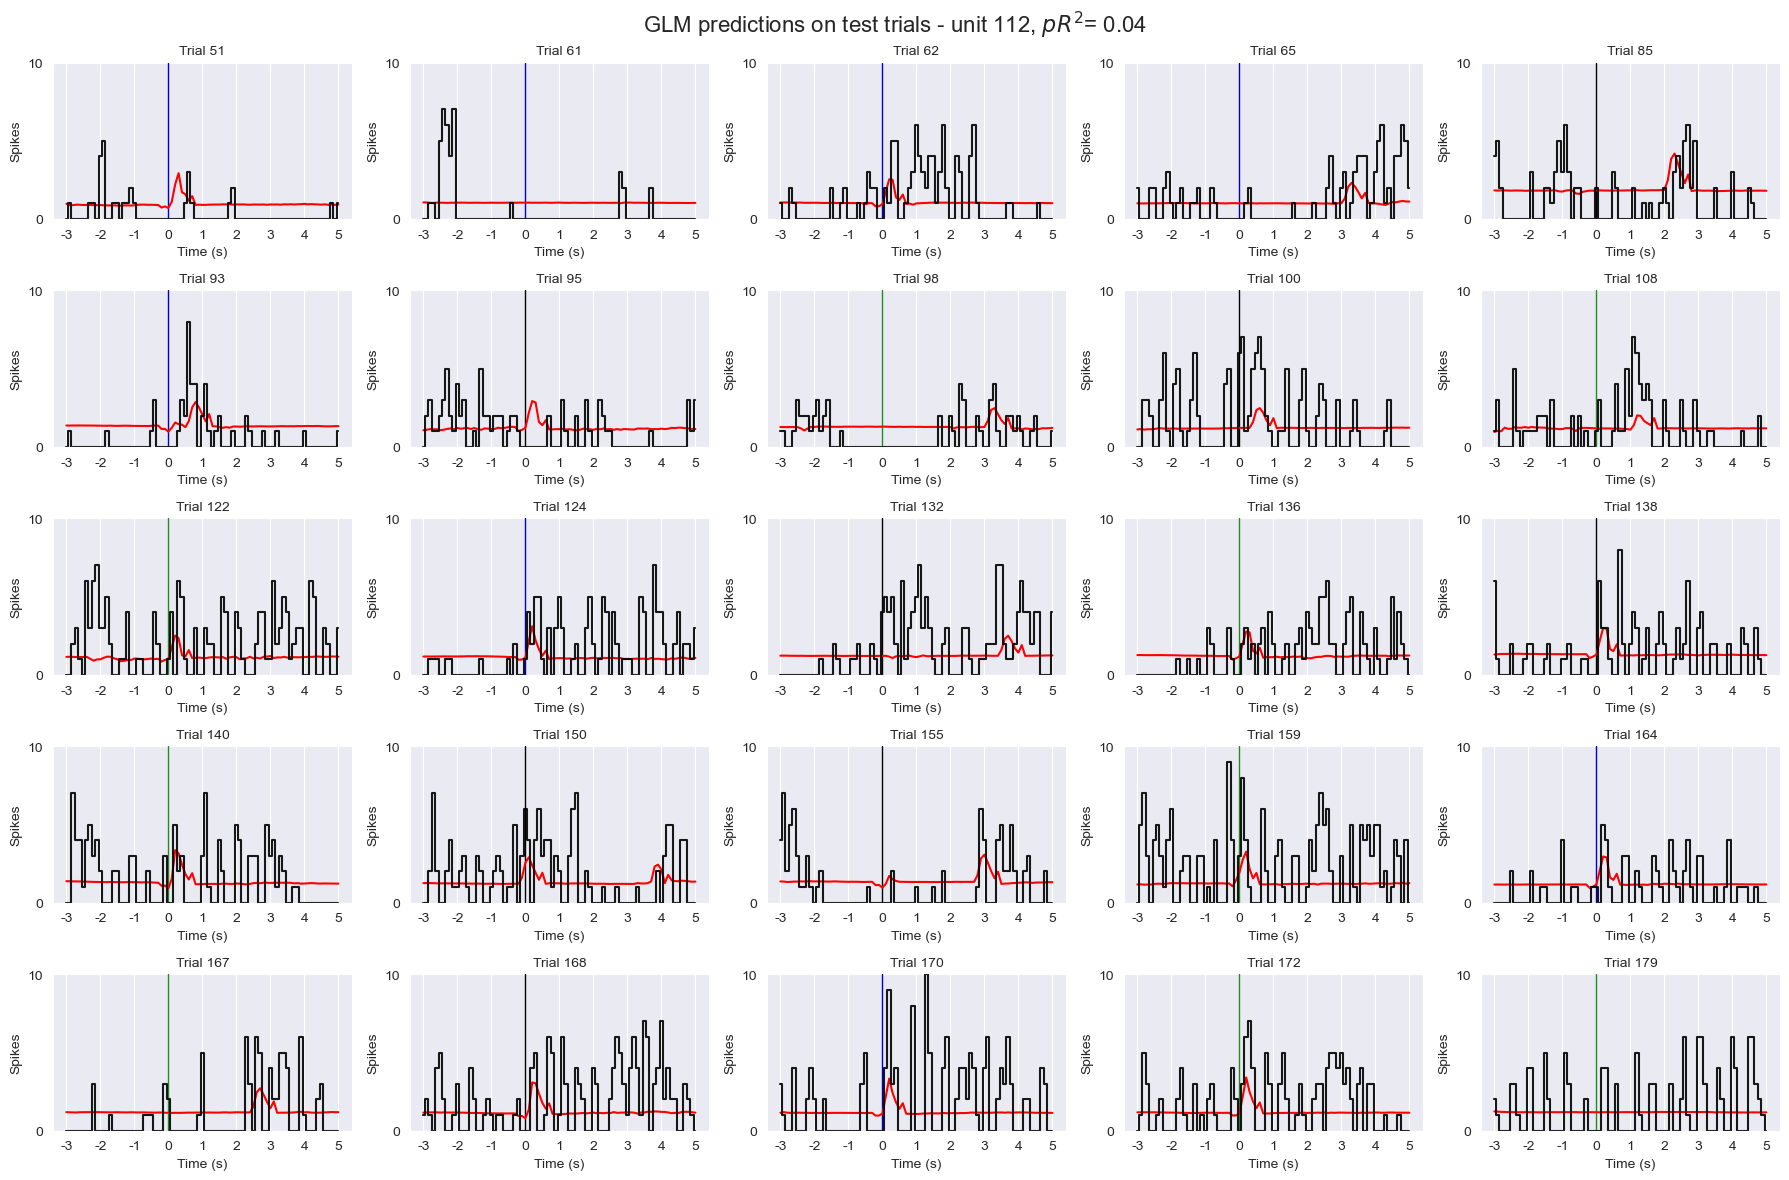

In [6]:
target_git_version = 'with prop_whisker_rewarded'

# Filter full and reduced models for the chosen git version
df_sub = df[df['git_version'] == target_git_version]
df_full = df_sub[df_sub['model_type'] == 'full']
df_reduced = df_sub[df_sub['model_type'] == 'reduced']

# Select neurons where the full model performed very well or poorly
n_select = 3
top_neurons = df_full.sort_values('test_corr', ascending=False).neuron_id.unique()[:n_select]
bottom_neurons = df_full.sort_values('test_corr', ascending=True).neuron_id.unique()[:n_select]
selected_neurons = np.concatenate([top_neurons, bottom_neurons])

for neuron_id in df_full.sort_values('test_corr', ascending=False).neuron_id.unique()[50:55]:
    # Plot full model
    full_model_df = df_full[df_full['neuron_id'] == neuron_id]
    if not full_model_df.empty:
        print(f"\nPlotting FULL model for neuron {neuron_id}")
        glm_utils.plot_trial_grid_predictions(full_model_df, trials_df, neuron_id, bin_size=0.1)

    # Plot all reduced models
    for model_name in ['session_progress_encoding', 'motor_encoding']:
        reduced_model_df = df_reduced[
            (df_reduced['neuron_id'] == neuron_id) &
            (df_reduced['model_name'] == model_name)
        ]
        if not reduced_model_df.empty:
            print(f"Plotting REDUCED model '{model_name}' for neuron {neuron_id}")
            glm_utils.plot_trial_grid_predictions(reduced_model_df, trials_df, neuron_id, bin_size=0.1)


In [48]:
df_reduced['model_name'].unique()

array(['whisker_encoding', 'auditory_encoding', 'whisker_reward_encoding',
       'auditory_reward_encoding', 'lick_onset_encoding',
       'motor_encoding', 'session_progress_encoding'], dtype=object)

In [22]:
df_full.keys()

Index(['neuron_id', 'lambda_opt', 'train_ll', 'train_score', 'train_corr',
       'train_mi', 'test_ll', 'test_score', 'coef', 'y_test', 'y_pred',
       'test_corr', 'test_mi', 'n_bins', 'fold', 'train_trials', 'test_trials',
       'model_name', 'predictors', 'git_version', 'model_type'],
      dtype='object')

In [119]:
git_versions = df['git_version'].unique()
df_full = df[df['model_type'] =='full']
sub_df = df_full[df_full['git_version'] == 'ad9dbf2']
unit_table['neuron_id'] = unit_table.index
unit_table.reset_index(drop=True, inplace=True)
merged = pd.merge(sub_df, unit_table, on="neuron_id", how="inner")


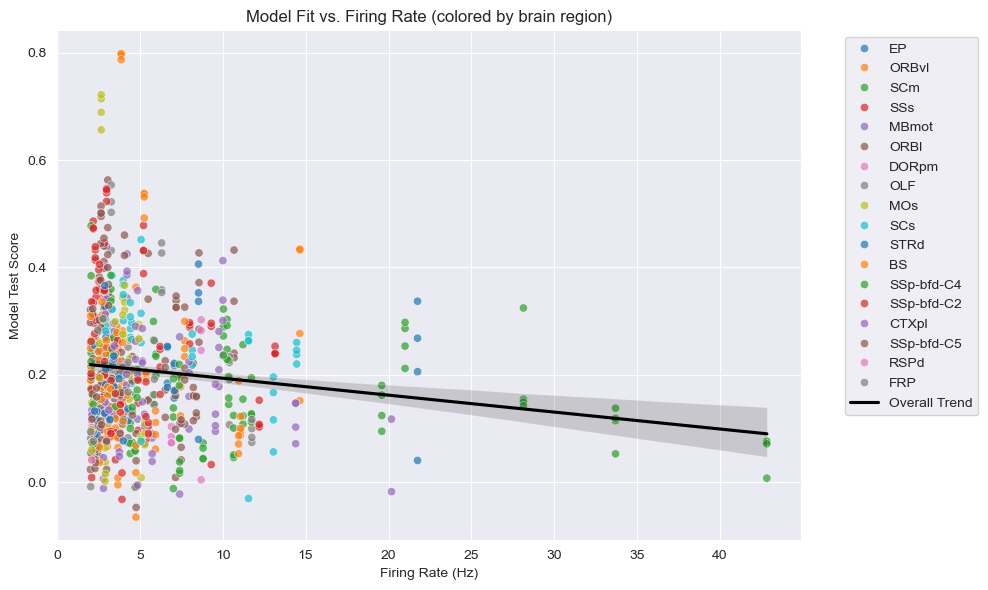

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
# Ensure numeric types
merged["firing_rate"] = pd.to_numeric(merged["firing_rate"], errors="coerce")
merged["test_score"] = pd.to_numeric(merged["test_corr"], errors="coerce")

# Drop rows with NaNs (from failed conversions)
merged_clean = merged.dropna(subset=["firing_rate", "test_corr", "ccf_parent_acronym"])

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_clean,
    x="firing_rate",
    y="test_score",
    hue="ccf_parent_acronym",
    palette="tab10",
    alpha=0.7
)
sns.regplot(
    data=merged_clean,
    x="firing_rate",
    y="test_score",
    scatter=False,
    color="black",
    label="Overall Trend"
)

plt.xlabel("Firing Rate (Hz)")
plt.ylabel("Model Test Score")
plt.title("Model Fit vs. Firing Rate (colored by brain region)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

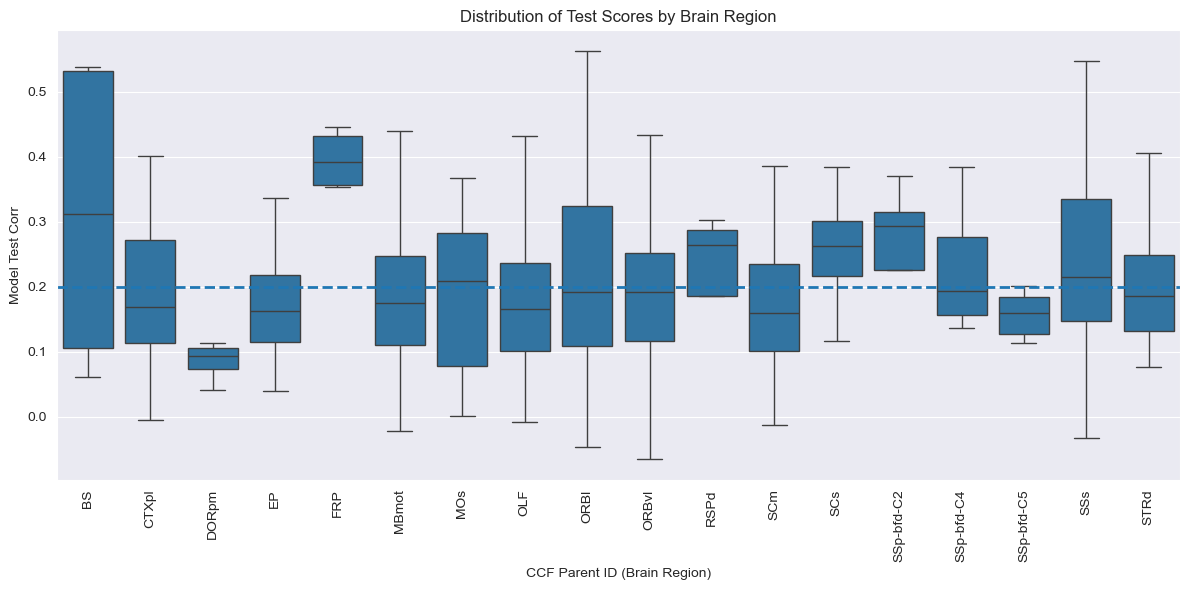

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
region_order = sorted(merged_clean["ccf_parent_acronym"].dropna().unique())

plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_clean, x="ccf_parent_acronym", y="test_corr", showfliers=False, order=region_order)
plt.xticks(rotation=90)
plt.xlabel("CCF Parent ID (Brain Region)")
plt.ylabel("Model Test Corr")
plt.axhline(0.2, linestyle='--', linewidth=2)
plt.title("Distribution of Test Scores by Brain Region")
plt.tight_layout()
plt.show()

In [59]:
region_order = sorted(merged_clean["ccf_parent_acronym"].dropna().unique())
merged_clean = merged.dropna(subset=["ccf_parent_name", "ccf_parent_acronym"])


In [58]:
region_order

['BS',
 'CTXpl',
 'DORpm',
 'EP',
 'FRP',
 'MBmot',
 'MOs',
 'OLF',
 'ORBl',
 'ORBvl',
 'RSPd',
 'SCm',
 'SCs',
 'SSp-bfd-C2',
 'SSp-bfd-C4',
 'SSp-bfd-C5',
 'SSs',
 'STRd']

In [123]:
import pandas as pd
import json

# Parse the JSON string to get the actual list of column names
column_names = json.loads(merged['predictors'].unique()[0])

# If predictors and coef are stored as strings of lists, convert them
merged["predictors"] = merged["predictors"].apply(lambda x: eval(x) if isinstance(x, str) else x)
merged["coef"] = merged["coef"].apply(lambda x: np.array(x) if isinstance(x, list) else x)

# Expand rows
rows = []
for _, row in merged.iterrows():
    rows_coefs = json.loads(row['coef'])
    for i, predictor in enumerate(column_names):
        rows.append({
            "neuron_id": row["neuron_id"],
            "predictor": predictor,
            "coef":rows_coefs[i],
            "firing_rate": row["firing_rate"],
            "ccf_parent_acronym": row["ccf_parent_acronym"]
        })

coef_df = pd.DataFrame(rows)

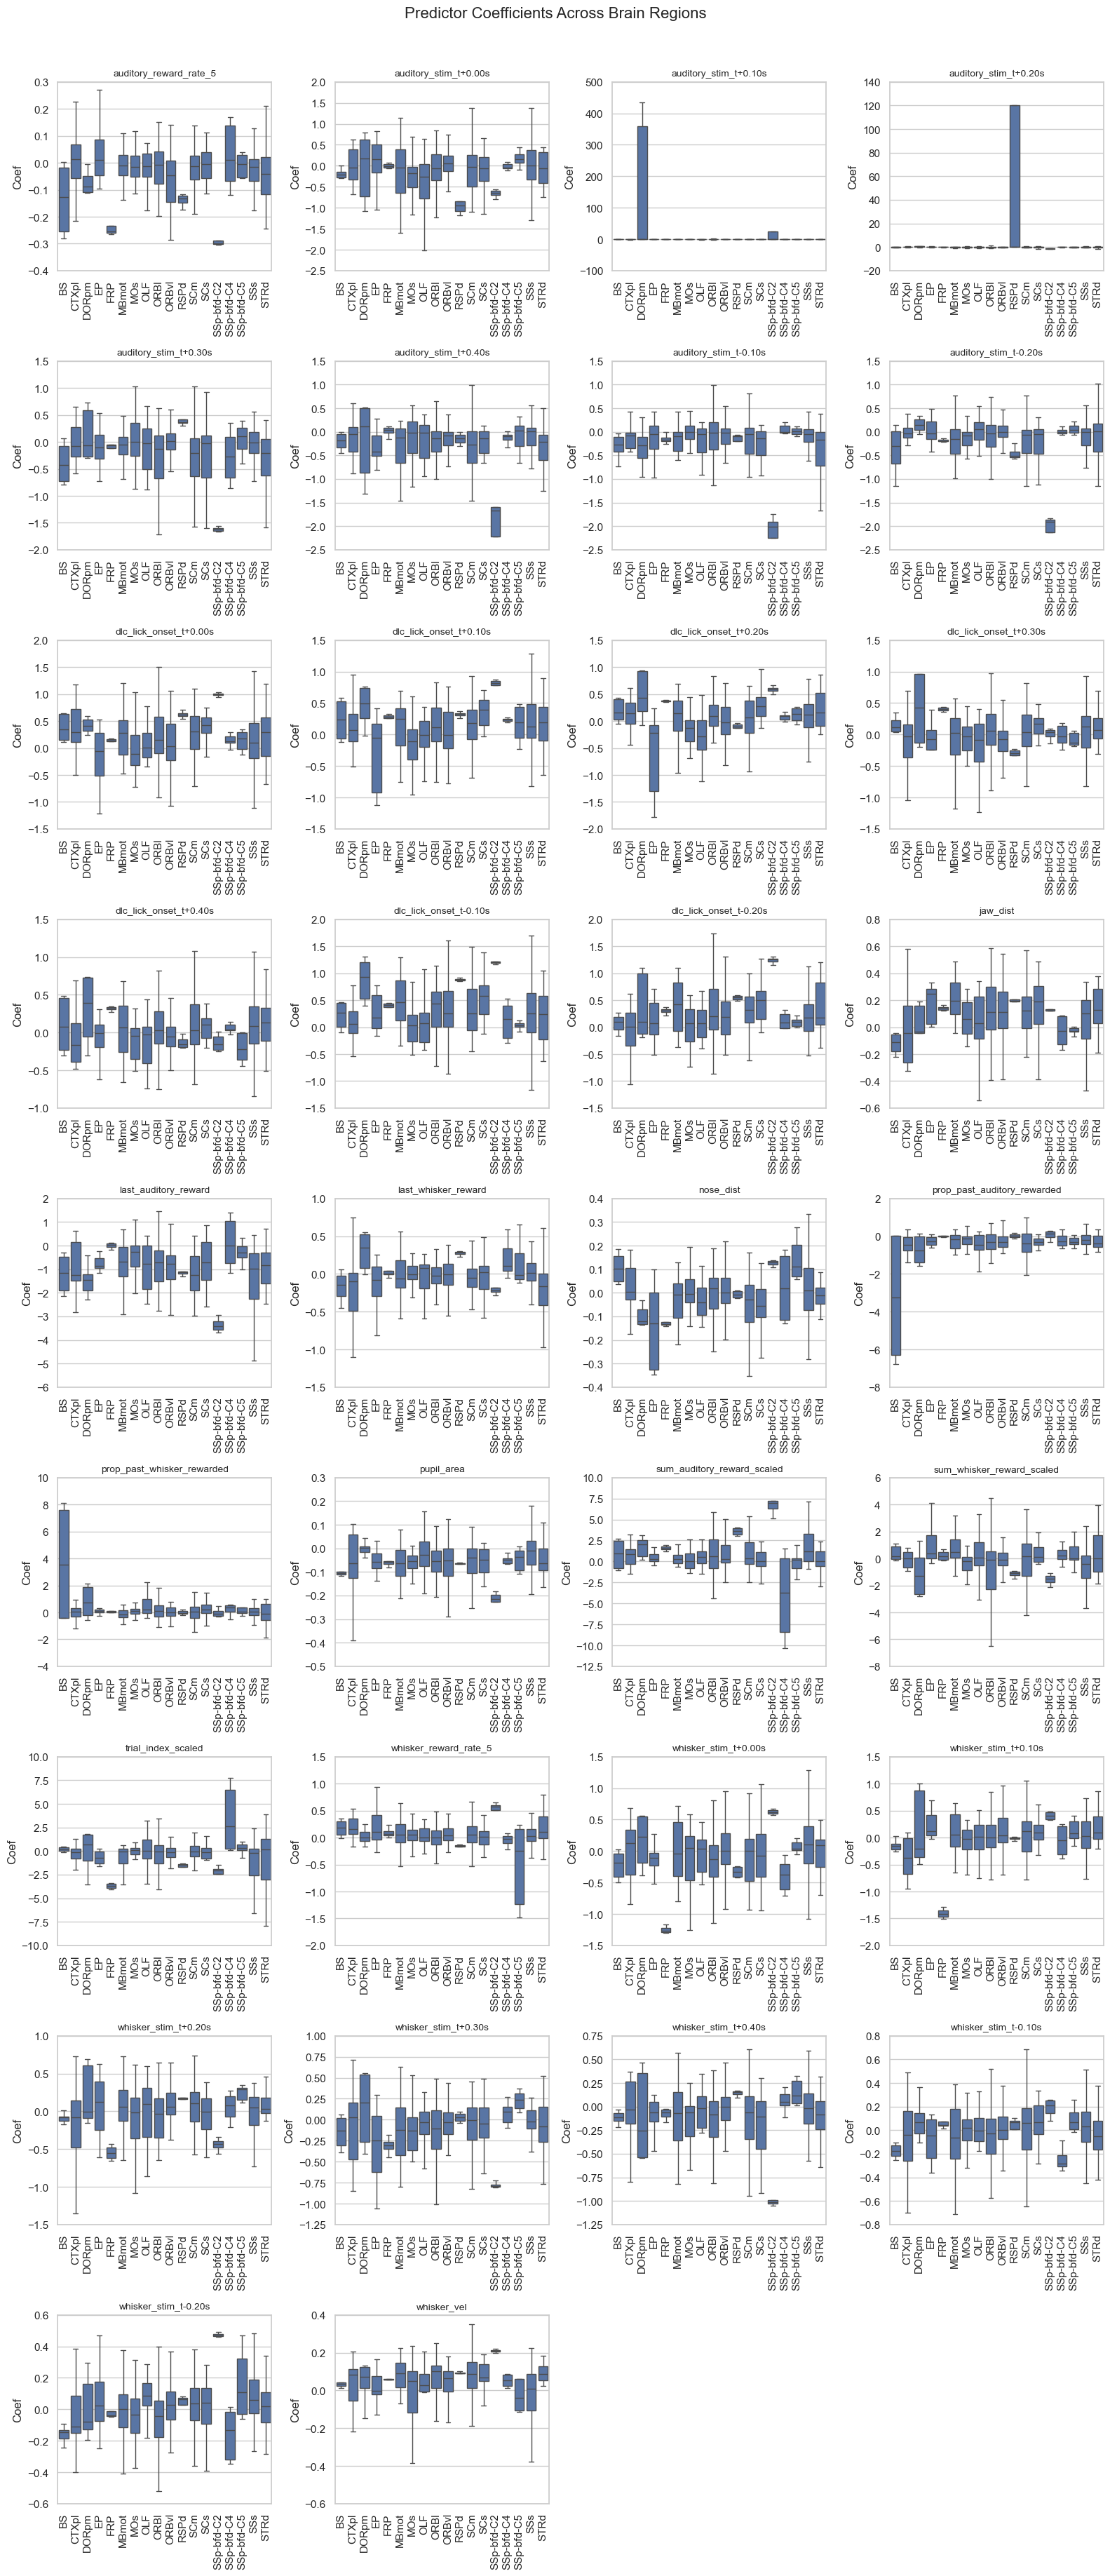

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
predictors = sorted(coef_df["predictor"].unique())

# Loop through predictors
n_cols = 4
n_rows = int(np.ceil(len(predictors) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharey=False)

for i, predictor in enumerate(predictors):
    ax = axes.flatten()[i]
    subset = coef_df[coef_df["predictor"] == predictor]

    # Sort regions alphabetically
    order = sorted(subset["ccf_parent_acronym"].unique())

    sns.boxplot(
        data=subset,
        x="ccf_parent_acronym",
        y="coef",
        order=order,
        ax=ax,
        showfliers=False
    )
    xticks = ax.get_xticks()
    xticklabels = ax.get_xticklabels()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=90)
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    ax.set_yticks(yticks)

    ax.set_title(predictor, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("Coef")

# Remove empty subplots
for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.suptitle("Predictor Coefficients Across Brain Regions", y=1.02, fontsize=16)
plt.show()



In [126]:
coef_df

neuron_id                    predictor      coef firing_rate  \
0              0           trial_index_scaled -0.285377  4.26864772   
1              0          last_whisker_reward  0.090435  4.26864772   
2              0         last_auditory_reward -0.930902  4.26864772   
3              0   prop_past_whisker_rewarded  0.087731  4.26864772   
4              0  prop_past_auditory_rewarded -0.319250  4.26864772   
...          ...                          ...       ...         ...   
27195        199         whisker_stim_t+0.40s  0.319375  2.08495654   
27196        199                     jaw_dist  0.167150  2.08495654   
27197        199                   pupil_area -0.038419  2.08495654   
27198        199                  whisker_vel  0.013041  2.08495654   
27199        199                    nose_dist -0.031030  2.08495654   

      ccf_parent_acronym  
0                     EP  
1                     EP  
2                     EP  
3                     EP  
4                     EP  
...                  ...  
27195              DORpm  
27196              DORpm  
27197              DORpm  
27198              DORpm  
27199              DORpm  

[27200 rows x 5 columns]